# TESS Atlas fit for TOI 393

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 393.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-393.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-393.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-393.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 393

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 393 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

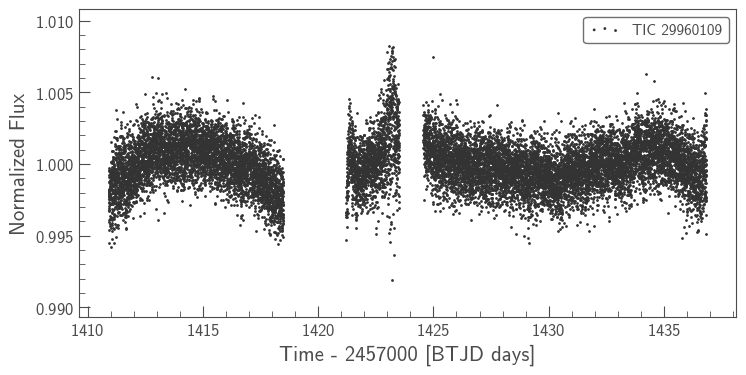

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -35953.31794107748 -> -35508.61339018881


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -27698.262078405256 -> -27167.862929780436


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -27167.862929780436 -> -27146.77923043834


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -27146.77923043834 -> -27146.77168835237


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -27146.77168835237 -> -27144.505020471817


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -27144.505020471817 -> -27144.416464705228


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -27144.416464705228 -> -27130.6713319982


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.6713319982 -> -27130.671331998114


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.671331998114 -> -27130.671331998034


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.671331998034 -> -27130.671331998034


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.671331998034 -> -27130.671331998034


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.671331998034 -> -27130.671331997983


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -27130.671331997983 -> -27130.671331997983


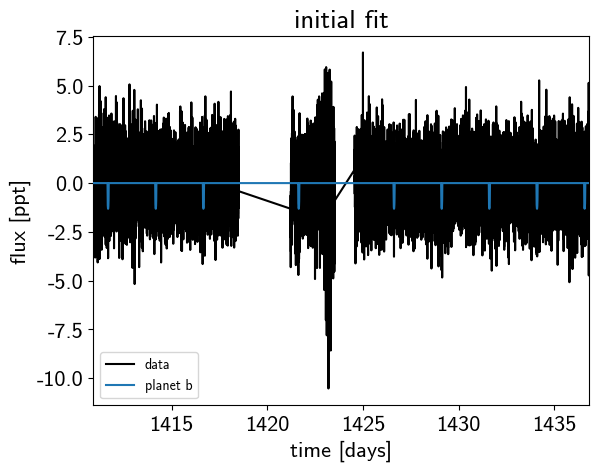

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 13.36draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:14,  6.52draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:14,  6.46draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:24,  3.74draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:27,  3.35draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.73draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:32,  2.77draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:28,  3.01draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:27,  3.09draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:27,  3.09draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:29,  2.88draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:27,  2.98draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:31,  2.61draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:27,  2.97draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:37,  2.14draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:06<00:33,  2.33draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:28,  2.72draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:26,  2.90draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:29,  2.53draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:26,  2.80draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:24,  2.96draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:24,  2.85draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:29,  2.36draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:22,  3.06draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:10<00:25,  2.69draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:10<00:26,  2.50draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:20,  3.15draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:26,  2.45draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:11<00:20,  3.16draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:22,  2.74draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:20,  3.06draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:12<00:20,  2.93draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:20,  2.90draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:17,  3.40draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:13<00:21,  2.72draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:18,  2.98draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:14<00:16,  3.41draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:14<00:18,  2.99draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:15,  3.32draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:15<00:17,  3.02draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:15<00:16,  3.13draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:15,  3.24draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:16<00:20,  2.42draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:19,  2.43draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:17<00:15,  2.99draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:18<00:16,  2.76draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:18<00:18,  2.33draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:18<00:14,  3.00draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:16,  2.48draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:14,  2.69draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:20<00:12,  3.14draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:20<00:12,  2.94draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:14,  2.51draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:21<00:12,  2.76draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:14,  2.39draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:22<00:12,  2.57draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:23<00:11,  2.78draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:23<00:10,  2.93draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:23<00:09,  2.96draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:09,  3.07draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:24<00:09,  2.86draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:24<00:08,  2.99draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:08,  2.93draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:25<00:06,  3.44draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:08,  2.79draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:25<00:06,  3.51draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:26<00:07,  2.67draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:07,  2.70draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:06,  2.78draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:28<00:04,  3.02draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:28<00:04,  3.36draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:29<00:05,  2.48draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:30<00:07,  1.71draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:31<00:07,  1.52draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:31<00:04,  2.03draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:32<00:05,  1.72draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:32<00:05,  1.58draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:33<00:04,  1.51draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:34<00:04,  1.47draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:35<00:03,  1.39draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:35<00:02,  1.40draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:36<00:02,  1.42draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:37<00:01,  1.46draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:37<00:00,  1.46draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:40<00:00,  1.32s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:01, 76.68draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:10,  8.76draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:16,  5.59draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:19,  4.61draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:27,  3.21draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:26,  3.15draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:22,  3.71draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:27,  2.98draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:24,  3.41draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:25,  3.22draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:24,  3.23draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:22,  3.44draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:26,  2.92draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:25,  3.06draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:26,  2.83draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:21,  3.42draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:26,  2.82draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:24,  2.90draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:19,  3.64draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:22,  3.06draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:20,  3.38draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:20,  3.37draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:22,  3.02draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:18,  3.58draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:24,  2.69draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:21,  2.96draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:21,  2.91draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:21,  2.94draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:17,  3.56draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:20,  2.86draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:16,  3.64draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:19,  2.91draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:16,  3.35draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:17,  3.24draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:13<00:17,  3.11draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:18,  2.90draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:17,  3.05draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:19,  2.73draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:14<00:14,  3.46draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:12,  3.98draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:16,  2.89draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:15,  3.02draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:16,  2.89draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:16<00:15,  2.93draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:14,  3.03draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:15,  2.79draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:17<00:15,  2.83draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:17<00:14,  2.82draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:13,  3.09draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:18<00:15,  2.54draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:13,  2.85draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:19<00:11,  3.18draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:11,  3.22draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:19<00:12,  2.72draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:20<00:11,  2.92draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:10,  3.10draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:21<00:11,  2.66draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:21<00:11,  2.57draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:22<00:10,  2.67draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:22<00:11,  2.54draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:22<00:08,  3.08draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:23<00:10,  2.50draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:23<00:08,  2.87draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:24<00:07,  2.91draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:24<00:06,  3.10draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:04,  3.82draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:25<00:05,  3.17draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:04,  3.42draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:26<00:04,  3.27draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:26<00:04,  3.03draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:04,  3.48draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:27<00:04,  2.62draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:27<00:04,  2.67draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:28<00:05,  1.78draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:29<00:05,  1.57draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:29<00:04,  1.99draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:30<00:04,  1.72draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:03,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:03,  1.49draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:02,  1.46draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:33<00:01,  1.79draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:33<00:01,  1.67draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:34<00:00,  1.62draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:37<00:00,  1.38s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:00,  1.69draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:34,  2.14draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:18,  2.53draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:21,  2.44draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:12,  2.72draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:20,  2.43draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:10,  2.76draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:05,  2.96draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<00:54,  3.51draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:03<01:06,  2.89draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:04<01:00,  3.12draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:04<00:55,  3.39draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:04<00:57,  3.27draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:05<00:58,  3.20draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:05<00:55,  3.35draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:05<01:03,  2.91draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:06<00:52,  3.48draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:06<01:07,  2.71draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:06<00:50,  3.56draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:07<00:48,  3.75draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:07<00:59,  3.00draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:08<01:00,  2.93draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:08<00:48,  3.65draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:08<00:40,  4.33draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:08<00:54,  3.20draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:09<00:50,  3.45draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:09<00:50,  3.41draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:09<00:53,  3.22draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:10<00:47,  3.56draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:10<00:56,  3.01draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:10<00:45,  3.72draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:10<00:40,  4.08draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:11<00:54,  3.03draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:11<00:48,  3.38draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:12<01:00,  2.70draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:12<00:48,  3.37draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:12<00:46,  3.44draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:12<00:48,  3.29draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:13<00:44,  3.54draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:13<00:58,  2.70draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:13<00:46,  3.37draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:14<00:59,  2.64draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:14<00:57,  2.70draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:15<00:49,  3.09draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:15<00:39,  3.87draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:15<00:54,  2.78draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:16<00:52,  2.84draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:16<00:41,  3.56draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:16<00:32,  4.49draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:17<00:34,  4.21draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:17<00:29,  4.83draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:17<00:22,  6.36draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:18<00:30,  4.57draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:18<00:45,  3.07draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:19<00:38,  3.55draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:19<00:40,  3.32draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:19<00:39,  3.38draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:20<00:38,  3.43draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:20<00:40,  3.26draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:21<00:46,  2.83draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:21<00:36,  3.58draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:21<00:35,  3.60draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:21<00:40,  3.17draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:22<00:41,  3.07draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:22<00:36,  3.46draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:22<00:43,  2.84draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:23<00:34,  3.59draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:23<00:32,  3.72draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:23<00:29,  4.02draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:23<00:24,  4.87draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:24<00:37,  3.12draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:24<00:27,  4.15draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:24<00:26,  4.38draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:25<00:42,  2.66draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:26<00:42,  2.64draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:26<00:36,  3.04draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:27<00:36,  2.97draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:27<00:35,  2.97draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:27<00:30,  3.42draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:28<00:36,  2.89draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:28<00:37,  2.77draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:29<00:37,  2.70draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:30<00:37,  2.65draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:31<00:37,  2.64draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:31<00:28,  3.41draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:31<00:37,  2.56draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:32<00:34,  2.72draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:33<00:30,  3.00draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:33<00:32,  2.76draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:33<00:23,  3.70draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:34<00:30,  2.81draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:34<00:27,  3.05draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:34<00:25,  3.24draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:35<00:25,  3.27draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:35<00:25,  3.16draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:35<00:26,  3.01draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:36<00:26,  2.99draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:36<00:24,  3.27draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:37<00:30,  2.58draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:37<00:26,  2.94draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:37<00:30,  2.46draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:37<00:23,  3.13draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:38<00:30,  2.46draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:39<00:27,  2.65draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:39<00:21,  3.34draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:39<00:25,  2.75draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:40<00:23,  2.90draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:40<00:23,  2.92draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:40<00:24,  2.74draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:41<00:20,  3.18draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:41<00:24,  2.64draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:41<00:20,  3.20draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:42<00:24,  2.61draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:42<00:20,  3.02draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:43<00:20,  2.86draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:44<00:20,  2.82draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:44<00:17,  3.21draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:45<00:21,  2.60draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:45<00:15,  3.36draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:45<00:19,  2.65draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:45<00:15,  3.33draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:46<00:18,  2.65draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:46<00:14,  3.39draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:47<00:16,  2.93draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:47<00:14,  3.28draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:47<00:14,  3.26draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:48<00:16,  2.81draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:48<00:15,  2.78draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:49<00:14,  2.80draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:49<00:10,  3.62draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:50<00:14,  2.59draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:51<00:13,  2.61draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:51<00:09,  3.43draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:51<00:10,  3.29draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:52<00:11,  2.77draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:52<00:10,  2.91draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:53<00:10,  2.78draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:53<00:08,  3.26draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:53<00:07,  3.62draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:53<00:08,  2.94draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:54<00:08,  3.01draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:54<00:07,  3.30draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:55<00:08,  2.63draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:55<00:06,  3.10draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:55<00:05,  3.73draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:56<00:06,  2.91draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:56<00:05,  3.30draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:56<00:05,  3.15draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:57<00:06,  2.66draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:57<00:07,  2.11draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:58<00:05,  2.21draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:59<00:06,  1.85draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:00<00:06,  1.61draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:00<00:06,  1.50draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:01<00:06,  1.42draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:02<00:06,  1.29draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:03<00:05,  1.29draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:04<00:04,  1.29draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:05<00:03,  1.28draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:05<00:03,  1.32draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:06<00:02,  1.36draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:07<00:01,  1.39draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:07<00:00,  1.42draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:11<00:00,  1.51s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:10, 39.32draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:17, 22.23draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:19, 20.57draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:24, 16.03draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:01<00:44,  8.69draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<00:39,  9.87draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:01<00:39,  9.72draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:34, 11.10draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:01<00:28, 13.55draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:01<00:26, 14.39draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:02<00:23, 15.94draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:02<00:22, 16.26draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:32, 11.34draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:34, 10.54draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:31, 11.77draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:03<00:35, 10.12draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:03<00:33, 10.87draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:03<00:27, 13.10draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:03<00:23, 14.96draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:03<00:18, 18.50draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:03<00:19, 17.90draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:04<00:20, 17.01draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:04<00:17, 19.21draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:04<00:16, 20.06draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:04<00:15, 21.66draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:04<00:12, 25.90draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:04<00:16, 19.64draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:05<00:21, 15.13draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:05<00:25, 12.55draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:05<00:24, 12.73draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:05<00:29, 10.74draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:06<00:33,  9.29draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:06<00:27, 11.15draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:06<00:26, 11.63draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:06<00:24, 12.37draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:06<00:23, 12.95draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:06<00:21, 14.26draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:07<00:16, 17.78draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:07<00:14, 20.70draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:07<00:13, 20.97draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:07<00:15, 18.32draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:07<00:16, 16.71draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:07<00:17, 15.99draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:07<00:16, 16.44draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:08<00:17, 15.58draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:08<00:16, 16.51draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:08<00:19, 14.26draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:08<00:18, 14.24draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:08<00:17, 15.39draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:08<00:18, 14.72draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:09<00:23, 11.02draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:09<00:21, 12.26draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:09<00:17, 14.85draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:09<00:16, 15.65draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:09<00:14, 17.17draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:09<00:13, 19.26draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:09<00:10, 22.57draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:09<00:10, 23.47draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:10<00:16, 14.55draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:10<00:17, 13.52draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:10<00:22, 10.61draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:11<00:21, 10.90draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:11<00:26,  8.73draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:11<00:24,  9.44draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:11<00:24,  9.05draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:12<00:23,  9.60draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:12<00:26,  8.25draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:12<00:27,  8.11draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:12<00:23,  9.39draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:13<00:24,  8.83draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:13<00:19, 10.97draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:13<00:17, 12.19draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:13<00:23,  9.00draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:13<00:23,  8.64draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:14<00:23,  8.71draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:14<00:21,  9.43draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:14<00:20,  9.74draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:14<00:23,  8.30draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:15<00:23,  8.44draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:15<00:19,  9.91draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:15<00:19,  9.67draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:15<00:16, 11.31draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:15<00:16, 11.62draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:15<00:13, 13.54draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:16<00:12, 14.91draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:16<00:11, 15.46draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:16<00:10, 17.27draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:16<00:09, 18.46draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:16<00:09, 17.43draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:16<00:10, 15.77draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:16<00:13, 12.34draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:17<00:13, 12.08draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:17<00:11, 14.38draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:17<00:09, 16.73draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:17<00:08, 17.90draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:17<00:09, 16.97draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:17<00:10, 14.39draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:18<00:11, 12.90draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:18<00:12, 11.85draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:18<00:10, 13.36draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:18<00:10, 13.16draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:18<00:13, 10.71draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:19<00:13, 10.32draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:19<00:17,  7.75draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:19<00:18,  7.45draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:19<00:13,  9.55draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:20<00:17,  7.27draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:20<00:14,  8.99draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:20<00:14,  8.88draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:20<00:13,  9.21draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:21<00:14,  8.64draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:21<00:12,  9.44draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:21<00:11,  9.98draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:21<00:11,  9.89draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:21<00:11, 10.10draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:21<00:09, 11.65draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:22<00:08, 12.78draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:22<00:07, 13.53draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:22<00:06, 15.35draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:22<00:07, 14.28draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:22<00:06, 15.85draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:22<00:07, 12.20draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:23<00:10,  8.77draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:23<00:11,  8.14draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:23<00:13,  6.68draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:24<00:14,  6.11draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:24<00:12,  6.87draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:24<00:23,  3.76draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:24<00:21,  4.14draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:25<00:25,  3.41draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:25<00:29,  2.84draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:26<00:28,  2.92draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:27<00:26,  3.04draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:27<00:22,  3.63draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:27<00:29,  2.64draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:28<00:29,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:28<00:29,  2.63draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:29<00:33,  2.25draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:29<00:26,  2.79draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:29<00:30,  2.41draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:30<00:24,  2.95draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:30<00:24,  2.84draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:30<00:19,  3.48draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:31<00:19,  3.54draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:31<00:17,  3.80draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:31<00:19,  3.35draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:32<00:16,  3.95draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:32<00:13,  4.55draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:32<00:14,  4.40draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:32<00:13,  4.52draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:32<00:11,  5.10draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:32<00:10,  5.43draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:33<00:09,  5.85draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:33<00:07,  7.13draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:33<00:06,  8.19draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:33<00:05,  9.01draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:33<00:04,  9.98draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:34<00:03, 12.77draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:34<00:03, 12.29draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:34<00:03, 12.05draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:34<00:02, 13.26draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:34<00:02, 12.43draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:34<00:02, 12.90draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:35<00:02, 12.06draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:35<00:02, 13.58draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:35<00:02, 12.34draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:35<00:01, 12.66draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:35<00:01, 11.44draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:36<00:01, 10.51draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:36<00:03,  5.62draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:37<00:04,  4.19draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:37<00:03,  4.46draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:37<00:03,  3.93draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:37<00:03,  4.14draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:38<00:03,  4.25draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:38<00:02,  4.35draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:38<00:02,  4.17draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:38<00:02,  4.10draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:39<00:02,  4.04draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:39<00:01,  4.88draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:39<00:01,  5.72draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:39<00:00,  6.50draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:39<00:00,  7.44draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:39<00:00,  6.76draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:39<00:00,  7.40draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:40<00:00,  7.80draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:40<00:00,  8.19draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:18, 42.54draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:22, 34.66draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:25, 30.97draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:25, 30.34draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:27, 28.50draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:00<00:24, 31.23draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:00<00:23, 32.90draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:01<00:25, 29.67draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:01<00:26, 29.34draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:27, 28.02draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:01<00:27, 27.61draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:01<00:27, 27.20draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:26, 28.39draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:01<00:28, 26.70draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:01<00:25, 28.97draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:23, 31.25draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:02<00:30, 24.16draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:02<00:32, 22.80draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:02<00:28, 25.69draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:02<00:24, 29.13draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:02<00:25, 28.17draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:03<00:26, 27.30draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:24, 29.54draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:03<00:29, 24.38draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:03<00:29, 23.86draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:03<00:32, 21.92draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:03<00:30, 22.61draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:03<00:32, 21.28draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:04<00:31, 22.08draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:04<00:32, 21.57draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:04<00:34, 20.05draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:04<00:49, 13.73draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:04<00:47, 14.34draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:05<01:00, 11.17draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:05<00:55, 12.28draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:05<00:54, 12.38draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:05<00:49, 13.50draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:05<00:45, 14.77draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:05<00:39, 16.80draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:06<01:01, 10.89draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:06<00:56, 11.85draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:06<00:50, 13.19draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:06<00:54, 12.23draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:06<00:46, 14.13draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:06<00:41, 15.76draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:07<00:38, 16.97draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:07<00:45, 14.23draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:07<00:54, 11.84draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:07<00:52, 12.23draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:07<00:49, 13.06draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:07<00:46, 13.85draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:08<00:46, 13.84draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:08<00:48, 13.09draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:08<00:58, 10.84draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:08<01:05,  9.73draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:08<01:10,  9.03draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:09<00:56, 11.05draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:09<01:03,  9.89draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:09<01:00, 10.40draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:09<00:57, 10.75draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:09<00:46, 13.37draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:09<00:42, 14.37draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:10<00:44, 13.81draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:10<00:45, 13.61draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:10<00:37, 16.19draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:10<00:35, 17.00draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:10<00:31, 18.94draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:10<00:42, 14.15draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:11<00:41, 14.51draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:11<00:48, 12.38draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:11<00:50, 11.73draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:11<00:46, 12.67draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:11<00:43, 13.60draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:11<00:47, 12.35draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:12<00:49, 11.76draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:12<00:46, 12.69draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:12<00:54, 10.77draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:12<00:54, 10.66draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:12<00:48, 11.84draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:13<00:50, 11.33draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:13<00:46, 12.38draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:13<00:39, 14.36draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:13<00:41, 13.64draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:13<00:39, 14.37draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:13<00:36, 15.57draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:13<00:38, 14.63draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:14<00:32, 17.06draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:14<00:31, 17.45draws/s]

Sampling 2 chains:  31%|███       | 249/804 [00:14<00:33, 16.36draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:14<00:32, 16.80draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:14<00:39, 14.07draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:14<00:42, 12.96draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:15<00:45, 12.00draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:15<00:52, 10.36draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:15<00:46, 11.60draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:15<00:48, 11.25draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:15<00:44, 12.15draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:15<00:36, 14.73draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:16<00:41, 12.78draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:16<00:43, 12.12draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:16<00:39, 13.46draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:16<00:35, 14.64draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:16<00:32, 16.30draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:16<00:30, 16.95draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:16<00:31, 16.64draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:17<00:28, 18.01draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:17<00:33, 15.24draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [00:17<00:38, 13.24draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:17<00:37, 13.72draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:17<00:38, 13.19draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:17<00:41, 12.28draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:18<00:44, 11.25draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:18<00:39, 12.82draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:18<00:32, 15.25draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:18<00:55,  9.00draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:18<00:47, 10.40draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:19<01:08,  7.14draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:19<01:28,  5.54draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:20<01:54,  4.27draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:20<01:54,  4.26draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:20<01:56,  4.16draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:21<01:44,  4.64draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:21<01:25,  5.61draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:21<01:15,  6.41draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:21<01:01,  7.73draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:21<00:55,  8.63draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:22<01:30,  5.24draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:22<01:18,  6.02draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:23<02:15,  3.49draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:23<03:20,  2.36draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:24<02:38,  2.98draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:24<03:02,  2.58draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:25<03:31,  2.22draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:25<03:22,  2.32draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:25<02:49,  2.76draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:26<03:19,  2.34draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:26<03:36,  2.15draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:27<03:35,  2.15draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:27<03:10,  2.42draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:28<03:16,  2.35draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:28<02:51,  2.68draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:28<02:16,  3.36draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [00:29<02:58,  2.56draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:29<02:24,  3.15draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:30<02:21,  3.20draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:30<02:07,  3.56draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:30<02:20,  3.21draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:31<01:55,  3.88draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:31<01:29,  4.98draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:31<01:52,  3.96draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:31<01:38,  4.52draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:32<01:34,  4.73draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:32<01:17,  5.74draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:32<01:43,  4.28draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:32<01:36,  4.56draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:33<01:41,  4.33draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:33<01:20,  5.42draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:33<01:09,  6.22draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:33<01:05,  6.64draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:34<00:58,  7.35draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:34<00:53,  8.07draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:34<00:44,  9.62draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:34<00:38, 10.93draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:34<00:35, 11.87draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:34<00:30, 13.78draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:34<00:25, 16.02draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:34<00:21, 19.55draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:35<00:18, 21.48draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:35<00:18, 21.67draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:35<00:17, 23.15draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:35<00:15, 25.02draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:35<00:14, 27.20draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:35<00:13, 29.60draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:35<00:12, 31.92draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:35<00:11, 32.37draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:36<00:12, 30.33draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:36<00:14, 25.99draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:36<00:16, 22.38draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:36<00:15, 23.64draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:36<00:15, 23.33draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:36<00:14, 24.86draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:37<00:14, 24.38draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:37<00:20, 17.62draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:37<00:17, 19.53draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:37<00:21, 15.91draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:37<00:20, 16.94draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:37<00:17, 19.36draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:38<00:20, 16.30draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:38<00:24, 13.48draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:38<00:31, 10.77draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:39<00:50,  6.56draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:39<00:42,  7.81draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:39<00:42,  7.66draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:39<00:43,  7.50draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:40<00:37,  8.72draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:40<00:33,  9.64draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:40<00:29, 10.67draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:40<00:27, 11.60draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:40<00:22, 13.89draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:40<00:18, 16.43draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:40<00:16, 18.66draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:41<00:16, 18.45draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:41<00:14, 20.21draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:41<00:15, 19.75draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:41<00:22, 13.34draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:41<00:20, 14.14draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:41<00:19, 15.41draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:42<00:19, 14.59draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:42<00:19, 14.64draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:42<00:21, 13.29draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:42<00:21, 13.00draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:42<00:19, 14.40draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:42<00:20, 13.64draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:43<00:18, 14.90draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:43<00:16, 17.04draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:43<00:19, 13.80draws/s]

Sampling 2 chains:  66%|██████▋   | 534/804 [00:43<00:24, 11.13draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:44<00:33,  8.10draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:44<00:34,  7.79draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:44<00:35,  7.52draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:44<00:39,  6.61draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:44<00:35,  7.40draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:45<00:30,  8.47draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:45<00:24, 10.54draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:45<00:25, 10.01draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:45<00:22, 11.03draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:45<00:18, 13.43draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:45<00:21, 11.78draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [00:46<00:22, 10.73draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:46<00:34,  7.02draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:46<00:35,  6.87draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:47<00:37,  6.40draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:47<00:39,  6.03draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:47<00:39,  5.99draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:47<00:41,  5.69draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:47<00:38,  6.09draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:48<00:35,  6.53draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:48<00:37,  6.13draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:48<00:38,  5.96draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:48<00:33,  6.81draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:48<00:30,  7.59draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:49<00:26,  8.58draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:49<00:22,  9.83draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:49<00:19, 11.08draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:49<00:19, 11.40draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:49<00:18, 11.92draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:49<00:17, 12.27draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:50<00:15, 13.93draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:50<00:14, 14.37draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:50<00:14, 14.48draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:50<00:14, 14.17draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:50<00:14, 14.49draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:50<00:13, 15.23draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:50<00:12, 16.18draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:51<00:11, 17.16draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:51<00:10, 18.12draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:51<00:10, 18.74draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:51<00:11, 16.26draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:51<00:12, 15.30draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:51<00:11, 15.71draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:51<00:10, 17.05draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:52<00:10, 16.73draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:52<00:10, 16.45draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:52<00:10, 16.49draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:52<00:11, 15.55draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:52<00:10, 16.40draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:52<00:10, 15.62draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:52<00:10, 16.02draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:52<00:10, 15.32draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:53<00:09, 17.50draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:53<00:09, 16.39draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:53<00:08, 19.07draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:53<00:07, 21.20draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:53<00:08, 17.38draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:53<00:08, 18.07draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:54<00:08, 17.34draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:54<00:08, 16.26draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:54<00:07, 17.76draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:54<00:07, 17.81draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:54<00:06, 20.09draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:54<00:06, 18.80draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:54<00:07, 18.28draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:54<00:07, 18.00draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:55<00:07, 17.47draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:55<00:07, 17.19draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:55<00:06, 19.22draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:55<00:06, 17.97draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:55<00:06, 18.12draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:55<00:05, 18.77draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:55<00:05, 18.75draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:56<00:06, 17.11draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:56<00:05, 18.45draws/s]

Sampling 2 chains:  88%|████████▊ | 705/804 [00:56<00:05, 19.73draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:57<00:11,  8.15draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:59<00:44,  2.11draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [01:02<01:07,  1.36draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [01:03<01:07,  1.34draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [01:04<01:09,  1.29draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [01:04<01:09,  1.28draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [01:05<01:09,  1.26draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [01:06<01:10,  1.24draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [01:07<00:58,  1.47draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [01:07<00:48,  1.75draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [01:07<00:41,  2.03draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [01:07<00:36,  2.25draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [01:08<00:34,  2.38draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [01:08<00:28,  2.88draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [01:09<00:31,  2.52draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:09<00:31,  2.52draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [01:09<00:26,  2.94draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [01:09<00:19,  3.90draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [01:09<00:16,  4.61draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [01:10<00:13,  5.47draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [01:10<00:11,  6.10draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [01:10<00:12,  5.90draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [01:10<00:11,  5.98draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:10<00:12,  5.57draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [01:10<00:11,  5.80draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [01:11<00:17,  3.82draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [01:11<00:21,  3.13draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [01:12<00:19,  3.32draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [01:12<00:23,  2.75draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [01:13<00:24,  2.55draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [01:13<00:23,  2.61draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [01:13<00:20,  3.02draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [01:13<00:16,  3.56draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [01:13<00:14,  4.00draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [01:14<00:10,  5.19draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [01:14<00:10,  5.28draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [01:14<00:08,  6.55draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [01:14<00:08,  6.25draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [01:14<00:08,  6.21draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [01:14<00:06,  7.46draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [01:15<00:06,  7.39draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [01:15<00:05,  8.15draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [01:15<00:05,  8.56draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [01:15<00:04,  9.84draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [01:15<00:04,  8.37draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [01:16<00:06,  6.61draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [01:16<00:08,  4.83draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [01:17<00:13,  2.83draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [01:17<00:17,  2.08draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [01:18<00:20,  1.74draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [01:18<00:15,  2.30draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [01:19<00:17,  1.91draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [01:19<00:13,  2.49draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [01:20<00:15,  2.08draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:20<00:13,  2.37draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [01:20<00:11,  2.56draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:21<00:14,  1.94draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [01:22<00:12,  2.23draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:22<00:12,  2.17draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [01:22<00:10,  2.47draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:23<00:10,  2.32draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [01:24<00:15,  1.52draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:25<00:19,  1.19draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [01:27<00:22,  1.03s/draws]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:29<00:28,  1.38s/draws]

Sampling 2 chains:  98%|█████████▊| 784/804 [01:31<00:31,  1.59s/draws]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:34<00:39,  2.07s/draws]

Sampling 2 chains:  98%|█████████▊| 786/804 [01:37<00:42,  2.35s/draws]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:40<00:41,  2.43s/draws]

Sampling 2 chains:  98%|█████████▊| 788/804 [01:42<00:39,  2.49s/draws]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:46<00:40,  2.71s/draws]

Sampling 2 chains:  98%|█████████▊| 790/804 [01:49<00:41,  2.94s/draws]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:53<00:40,  3.13s/draws]

Sampling 2 chains:  99%|█████████▊| 792/804 [01:56<00:36,  3.06s/draws]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:59<00:34,  3.15s/draws]

Sampling 2 chains:  99%|█████████▉| 794/804 [02:02<00:31,  3.16s/draws]

Sampling 2 chains:  99%|█████████▉| 795/804 [02:05<00:28,  3.13s/draws]

Sampling 2 chains:  99%|█████████▉| 796/804 [02:08<00:24,  3.02s/draws]

Sampling 2 chains:  99%|█████████▉| 797/804 [02:11<00:21,  3.08s/draws]

Sampling 2 chains:  99%|█████████▉| 798/804 [02:14<00:18,  3.08s/draws]

Sampling 2 chains:  99%|█████████▉| 799/804 [02:17<00:14,  2.96s/draws]

Sampling 2 chains: 100%|█████████▉| 800/804 [02:20<00:11,  2.87s/draws]

Sampling 2 chains: 100%|█████████▉| 801/804 [02:22<00:08,  2.86s/draws]

Sampling 2 chains: 100%|█████████▉| 802/804 [02:25<00:05,  2.76s/draws]

Sampling 2 chains: 100%|█████████▉| 803/804 [02:28<00:02,  2.75s/draws]

Sampling 2 chains: 100%|██████████| 804/804 [02:28<00:00,  5.42draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<07:30,  9.77draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<06:02, 12.15draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<06:37, 11.06draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<06:14, 11.73draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<05:42, 12.81draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<05:21, 13.65draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<04:49, 15.17draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<04:31, 16.13draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:43, 12.74draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:01<04:44, 15.40draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<04:31, 16.15draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:01<04:09, 17.55draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<04:00, 18.18draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:01<03:27, 21.09draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<03:46, 19.23draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:02<03:25, 21.27draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:02<03:18, 21.99draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<03:13, 22.46draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:02<03:12, 22.64draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:02<03:33, 20.37draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:02<03:17, 22.01draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:03<03:44, 19.39draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:03<04:21, 16.61draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<03:54, 18.50draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:03<04:49, 14.96draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:03<04:54, 14.73draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:04<05:07, 14.09draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:04<06:05, 11.86draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:04<06:26, 11.20draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:04<07:22,  9.76draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:05<08:20,  8.63draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:05<08:24,  8.56draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:05<08:39,  8.31draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:05<09:30,  7.57draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:06<10:24,  6.91draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:06<11:02,  6.51draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:06<09:01,  7.97draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:06<09:12,  7.80draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:06<08:20,  8.61draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:06<08:10,  8.78draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:07<08:24,  8.54draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:07<07:12,  9.96draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:07<07:00, 10.24draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:07<06:13, 11.53draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:07<07:00, 10.21draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:07<06:08, 11.66draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:07<05:43, 12.51draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:08<05:23, 13.27draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:08<05:26, 13.16draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:08<05:26, 13.16draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:08<05:06, 13.99draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:08<04:50, 14.75draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:08<04:36, 15.52draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:08<04:35, 15.53draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:09<04:18, 16.52draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:09<04:38, 15.37draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:09<03:50, 18.57draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:09<04:14, 16.76draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:09<05:17, 13.42draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:09<06:25, 11.06draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:10<05:59, 11.85draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:10<06:25, 11.06draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:10<07:04, 10.04draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:10<06:47, 10.45draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:10<05:53, 12.02draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:11<05:55, 11.98draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:11<05:50, 12.12draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:11<05:48, 12.20draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:11<05:34, 12.69draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:11<05:45, 12.30draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:11<05:45, 12.30draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:12<05:53, 11.99draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:12<05:15, 13.44draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:12<06:07, 11.54draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:12<06:07, 11.52draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:12<05:11, 13.59draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:12<05:31, 12.75draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:13<06:28, 10.89draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:13<06:06, 11.51draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:13<05:50, 12.06draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:13<05:20, 13.16draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:13<05:06, 13.76draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:13<06:01, 11.65draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:14<05:33, 12.62draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:14<07:04,  9.92draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:14<08:02,  8.73draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:14<07:42,  9.09draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:15<07:52,  8.89draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:15<08:06,  8.65draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:15<08:13,  8.52draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:15<08:01,  8.72draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:15<06:49, 10.25draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:15<07:00,  9.98draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:15<06:17, 11.13draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:16<05:37, 12.44draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:16<05:23, 12.96draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:16<04:47, 14.56draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:16<04:07, 16.91draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:16<03:56, 17.67draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:16<04:35, 15.19draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:16<04:29, 15.49draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:17<04:12, 16.52draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:17<03:48, 18.30draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:17<03:30, 19.84draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:17<03:37, 19.18draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:17<03:45, 18.46draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:17<03:48, 18.20draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:17<03:42, 18.66draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:18<04:34, 15.15draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:18<04:58, 13.92draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:18<04:24, 15.68draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:18<05:13, 13.22draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:18<05:05, 13.59draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:18<04:26, 15.53draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:19<05:10, 13.34draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:19<04:48, 14.36draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:19<04:28, 15.40draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:19<04:12, 16.37draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:19<04:33, 15.11draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:19<05:12, 13.22draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:20<06:01, 11.42draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:20<06:59,  9.85draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:20<07:20,  9.37draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:20<07:09,  9.61draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:20<06:39, 10.33draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:20<05:51, 11.71draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:21<06:45, 10.15draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:21<06:22, 10.78draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:21<06:39, 10.30draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:21<05:50, 11.72draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:21<05:38, 12.14draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:22<05:06, 13.38draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:22<04:48, 14.25draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:22<04:11, 16.28draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:22<04:42, 14.51draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:22<04:32, 15.02draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:22<05:05, 13.39draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:23<06:01, 11.31draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:23<06:04, 11.23draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:23<05:37, 12.11draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:23<06:29, 10.51draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:23<06:02, 11.26draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:23<05:27, 12.48draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:24<04:36, 14.79draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:24<03:54, 17.38draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:24<03:50, 17.68draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [00:24<03:27, 19.63draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:24<03:55, 17.25draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:24<03:41, 18.39draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:24<03:38, 18.62draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:25<03:42, 18.27draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:25<03:45, 18.01draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:25<03:39, 18.48draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:25<04:00, 16.87draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:25<05:13, 12.91draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:25<04:51, 13.90draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:26<05:01, 13.43draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:26<05:14, 12.87draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:26<05:34, 12.10draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:26<05:48, 11.59draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:26<05:04, 13.25draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:26<05:28, 12.29draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:27<05:03, 13.28draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:27<04:33, 14.75draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:27<04:38, 14.48draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:27<04:32, 14.81draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:27<04:47, 14.00draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:27<04:46, 14.04draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:28<05:29, 12.20draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:28<05:51, 11.42draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:28<05:18, 12.63draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:28<04:33, 14.67draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:28<05:04, 13.17draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:28<05:16, 12.65draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:28<04:55, 13.55draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:29<04:34, 14.59draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:29<03:53, 17.18draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:29<04:54, 13.58draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:29<04:37, 14.40draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:29<04:28, 14.90draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:29<04:04, 16.32draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:29<04:04, 16.32draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:30<04:24, 15.10draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:30<03:53, 17.04draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:30<05:09, 12.86draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:30<05:10, 12.84draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:30<06:05, 10.90draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:31<06:01, 10.99draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:31<06:00, 11.04draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:31<05:26, 12.17draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:31<04:35, 14.39draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:31<04:25, 14.96draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:31<04:22, 15.11draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:31<04:05, 16.12draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:31<04:05, 16.14draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:32<03:31, 18.75draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:32<03:15, 20.28draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:32<03:12, 20.56draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:32<03:37, 18.15draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:32<03:41, 17.79draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:32<04:20, 15.13draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:33<03:42, 17.72draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:33<03:59, 16.47draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:33<03:31, 18.58draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:33<03:15, 20.09draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:33<03:35, 18.24draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:33<03:44, 17.49draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:34<03:38, 17.96draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:34<03:19, 19.64draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:34<04:16, 15.29draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:34<05:23, 12.10draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:34<05:27, 11.96draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:35<05:32, 11.77draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:35<05:43, 11.37draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:35<05:11, 12.53draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:35<05:55, 10.99draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:35<05:15, 12.39draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:35<05:16, 12.34draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:35<04:25, 14.71draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:36<04:22, 14.84draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:36<04:24, 14.71draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:36<04:15, 15.23draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:36<04:38, 13.97draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:36<05:17, 12.25draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:36<05:57, 10.87draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:37<05:45, 11.26draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:37<06:35,  9.81draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:37<06:14, 10.35draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:37<06:02, 10.71draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:37<05:14, 12.34draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:38<05:20, 12.10draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:38<05:36, 11.49draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:38<05:37, 11.48draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:38<05:11, 12.43draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:38<05:31, 11.66draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:38<05:12, 12.36draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:39<05:07, 12.54draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:39<04:49, 13.35draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:39<04:45, 13.51draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:39<05:34, 11.52draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:39<05:21, 11.98draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:39<04:24, 14.56draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:40<04:14, 15.14draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:40<04:01, 15.91draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:40<03:28, 18.42draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:40<05:21, 11.93draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:40<04:45, 13.43draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:41<05:59, 10.66draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:41<06:00, 10.63draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:41<05:44, 11.11draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:41<04:47, 13.31draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:41<04:54, 12.98draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:42<05:35, 11.38draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:42<05:05, 12.49draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:42<04:20, 14.65draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:42<04:45, 13.37draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:42<04:21, 14.59draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:42<04:14, 14.99draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [00:43<05:16, 12.05draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:43<04:49, 13.13draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:43<04:30, 14.04draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:43<04:18, 14.70draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:43<04:24, 14.39draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:43<04:36, 13.73draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:43<04:13, 14.96draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:44<04:37, 13.68draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:44<04:05, 15.41draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:44<03:54, 16.18draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:44<03:42, 17.01draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:44<03:58, 15.86draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:44<04:00, 15.71draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:44<03:45, 16.78draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:44<03:48, 16.50draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:45<03:20, 18.83draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:45<03:29, 18.02draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:45<03:49, 16.46draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:45<03:50, 16.33draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:45<03:56, 15.93draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:45<04:06, 15.24draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:45<03:52, 16.20draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:46<04:29, 13.94draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:46<03:59, 15.70draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:46<03:55, 15.92draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:46<03:57, 15.77draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:46<04:17, 14.56draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:46<05:15, 11.88draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:47<05:22, 11.60draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:47<04:21, 14.32draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:47<04:39, 13.40draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:47<05:11, 12.01draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:47<05:15, 11.85draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:47<04:37, 13.44draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:48<04:13, 14.69draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:48<04:03, 15.32draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:48<03:32, 17.51draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [00:48<03:13, 19.21draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:48<03:08, 19.74draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:48<02:49, 21.97draws/s]

Sampling 2 chains:  16%|█▌        | 692/4404 [00:48<02:37, 23.60draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:48<02:50, 21.76draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:49<03:14, 19.08draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:49<03:23, 18.21draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:49<04:42, 13.11draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:49<05:43, 10.77draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:50<08:15,  7.47draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:50<11:16,  5.46draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:51<11:03,  5.56draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:51<11:09,  5.51draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:51<14:05,  4.36draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:51<12:54,  4.77draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:51<11:46,  5.22draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:52<12:06,  5.08draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:52<15:06,  4.07draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [00:52<13:11,  4.66draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:52<13:25,  4.58draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:53<15:06,  4.06draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:53<14:26,  4.25draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:53<12:20,  4.97draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:53<10:32,  5.82draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:53<09:50,  6.23draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [00:54<10:26,  5.87draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:54<15:52,  3.86draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:55<15:47,  3.88draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [00:55<11:56,  5.13draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:55<17:43,  3.45draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:56<18:49,  3.25draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:57<25:04,  2.44draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:58<27:04,  2.26draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:58<24:36,  2.48draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:59<29:28,  2.07draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:59<31:53,  1.92draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:59<26:32,  2.30draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [01:00<31:29,  1.94draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [01:00<26:33,  2.30draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [01:01<28:31,  2.14draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [01:01<22:23,  2.72draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [01:02<27:02,  2.25draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [01:02<21:42,  2.81draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [01:02<24:01,  2.54draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [01:03<20:32,  2.96draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [01:03<23:14,  2.62draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [01:03<19:03,  3.19draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [01:04<24:45,  2.46draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [01:05<23:39,  2.57draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [01:05<23:00,  2.64draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [01:05<18:06,  3.36draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [01:06<19:24,  3.13draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [01:06<18:59,  3.20draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [01:07<26:25,  2.30draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [01:07<25:59,  2.34draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [01:08<26:03,  2.33draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [01:08<22:14,  2.73draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:08<22:36,  2.68draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [01:08<17:48,  3.40draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:09<16:44,  3.62draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [01:09<21:04,  2.88draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:09<18:09,  3.34draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [01:10<18:58,  3.19draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:10<15:21,  3.94draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [01:10<15:11,  3.98draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:10<16:49,  3.60draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [01:11<14:01,  4.32draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:11<13:52,  4.36draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [01:11<16:01,  3.78draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:11<12:58,  4.66draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [01:11<12:48,  4.71draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [01:12<12:09,  4.97draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:12<12:09,  4.97draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [01:12<10:23,  5.80draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:12<10:45,  5.61draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [01:12<10:56,  5.51draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [01:13<11:30,  5.24draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [01:13<09:35,  6.29draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [01:13<09:09,  6.58draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:13<07:47,  7.72draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [01:13<06:50,  8.80draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [01:14<05:40, 10.58draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:14<05:30, 10.92draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [01:14<05:20, 11.23draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [01:14<05:13, 11.49draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:14<05:19, 11.25draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [01:14<04:49, 12.41draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [01:15<04:18, 13.89draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:15<04:32, 13.16draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [01:15<03:53, 15.34draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [01:15<03:41, 16.22draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [01:15<03:19, 17.92draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [01:15<03:39, 16.30draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:16<06:12,  9.60draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:16<09:36,  6.21draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [01:17<09:18,  6.40draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [01:17<11:14,  5.30draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [01:17<12:28,  4.78draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [01:17<15:09,  3.93draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [01:18<16:37,  3.58draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [01:18<22:14,  2.68draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [01:19<20:44,  2.87draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [01:19<25:51,  2.30draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [01:20<24:01,  2.47draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [01:20<21:31,  2.76draws/s]

Sampling 2 chains:  19%|█▉        | 840/4404 [01:21<22:02,  2.70draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [01:21<21:06,  2.81draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [01:22<20:42,  2.87draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [01:22<20:40,  2.87draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [01:23<20:29,  2.89draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [01:24<19:56,  2.97draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [01:24<16:23,  3.61draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [01:24<23:31,  2.52draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [01:25<22:53,  2.58draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [01:25<19:39,  3.01draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [01:26<23:07,  2.56draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [01:26<18:26,  3.21draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [01:26<15:23,  3.84draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [01:26<16:35,  3.56draws/s]

Sampling 2 chains:  20%|█▉        | 859/4404 [01:27<13:46,  4.29draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [01:27<13:25,  4.40draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [01:27<15:23,  3.84draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [01:27<13:36,  4.34draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [01:27<12:29,  4.72draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [01:28<14:41,  4.02draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [01:28<14:45,  4.00draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [01:28<13:46,  4.28draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [01:29<12:24,  4.75draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [01:29<11:19,  5.21draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [01:29<11:20,  5.19draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [01:29<10:51,  5.42draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:29<10:28,  5.62draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [01:29<09:30,  6.19draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [01:30<09:50,  5.98draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [01:30<09:40,  6.08draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [01:30<09:46,  6.02draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [01:30<08:19,  7.05draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [01:30<08:54,  6.59draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [01:31<08:59,  6.53draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [01:31<08:14,  7.12draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [01:31<07:34,  7.75draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [01:31<06:44,  8.70draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [01:31<06:06,  9.59draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [01:31<05:20, 10.97draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [01:32<05:38, 10.38draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [01:32<04:55, 11.87draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [01:32<05:01, 11.63draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [01:32<04:07, 14.16draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [01:32<03:21, 17.34draws/s]

Sampling 2 chains:  21%|██        | 907/4404 [01:33<06:16,  9.29draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [01:33<06:20,  9.19draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [01:34<09:36,  6.06draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [01:34<08:30,  6.84draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [01:34<09:37,  6.04draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [01:34<08:04,  7.20draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [01:35<08:30,  6.82draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [01:35<08:54,  6.51draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:35<07:44,  7.50draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [01:35<07:09,  8.10draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [01:36<06:58,  8.31draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [01:36<07:30,  7.71draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [01:36<06:58,  8.30draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [01:36<06:41,  8.66draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [01:36<07:20,  7.89draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [01:36<06:36,  8.75draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [01:36<06:01,  9.59draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [01:37<06:14,  9.25draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [01:37<06:22,  9.06draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [01:37<06:35,  8.75draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [01:37<06:41,  8.62draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [01:37<06:46,  8.51draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [01:37<06:52,  8.39draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:37<06:57,  8.29draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [01:38<05:54,  9.75draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [01:38<05:16, 10.94draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [01:38<04:59, 11.52draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:38<04:33, 12.62draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:38<05:16, 10.91draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:38<05:44, 10.02draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [01:39<05:06, 11.26draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [01:39<05:38, 10.17draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:39<05:59,  9.59draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:39<05:45,  9.95draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [01:39<05:16, 10.87draws/s]

Sampling 2 chains:  22%|██▏       | 968/4404 [01:40<04:50, 11.84draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [01:40<05:13, 10.97draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [01:40<04:55, 11.62draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [01:40<04:26, 12.86draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [01:40<03:43, 15.35draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [01:40<03:31, 16.20draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [01:40<03:27, 16.48draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:41<03:25, 16.67draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [01:41<03:23, 16.77draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:41<03:03, 18.62draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [01:41<03:33, 15.96draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [01:41<03:44, 15.18draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [01:41<03:13, 17.60draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [01:41<03:14, 17.50draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [01:42<02:57, 19.16draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [01:42<02:48, 20.12draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [01:42<02:44, 20.62draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [01:42<02:27, 22.96draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:42<02:57, 19.06draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [01:42<02:43, 20.70draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [01:42<02:59, 18.79draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:43<03:17, 17.14draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:43<03:48, 14.80draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:43<04:31, 12.42draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:43<04:09, 13.54draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [01:43<04:23, 12.78draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:44<04:10, 13.42draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:44<04:07, 13.62draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:44<03:55, 14.30draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:44<04:23, 12.77draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:44<04:23, 12.77draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:44<04:44, 11.78draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:45<04:21, 12.85draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:45<06:04,  9.20draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [01:45<05:48,  9.60draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [01:45<05:50,  9.55draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [01:46<05:10, 10.78draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [01:46<04:54, 11.34draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [01:46<04:29, 12.40draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [01:46<04:10, 13.31draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:46<03:49, 14.56draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:46<03:38, 15.25draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:46<04:06, 13.53draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:47<03:53, 14.27draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:47<04:08, 13.39draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:47<03:51, 14.38draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:47<03:41, 14.99draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:47<03:51, 14.35draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:47<04:01, 13.73draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:47<03:29, 15.82draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:48<03:42, 14.90draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [01:48<03:33, 15.51draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:48<03:33, 15.47draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:48<04:00, 13.77draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [01:48<03:35, 15.35draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [01:48<03:36, 15.27draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:49<03:41, 14.88draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:49<04:18, 12.76draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:49<03:59, 13.74draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [01:49<04:47, 11.47draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [01:49<05:06, 10.74draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:50<05:04, 10.81draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [01:50<04:36, 11.90draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [01:50<04:06, 13.32draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [01:50<04:11, 13.06draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:50<04:44, 11.55draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:50<03:53, 14.02draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [01:50<04:24, 12.38draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [01:51<04:34, 11.92draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [01:51<04:30, 12.10draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [01:51<04:29, 12.13draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [01:51<04:29, 12.14draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:51<04:42, 11.58draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:51<04:03, 13.43draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:52<04:01, 13.51draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:52<03:54, 13.91draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:52<03:53, 13.93draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:52<04:20, 12.48draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:52<04:13, 12.84draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [01:52<03:51, 14.05draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:53<04:51, 11.16draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:53<04:53, 11.07draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:53<04:20, 12.47draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [01:53<04:15, 12.67draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [01:53<04:10, 12.93draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [01:54<04:39, 11.58draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:54<04:42, 11.44draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [01:54<05:31,  9.76draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:54<05:49,  9.24draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [01:54<06:46,  7.95draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [01:55<07:26,  7.23draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [01:55<06:30,  8.27draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:55<07:17,  7.38draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:55<08:05,  6.65draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:55<07:33,  7.10draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:56<06:29,  8.26draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:56<05:43,  9.38draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [01:56<04:52, 11.00draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:56<04:37, 11.58draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:56<04:18, 12.44draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:56<04:01, 13.28draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:56<04:42, 11.37draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:57<04:25, 12.05draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:57<04:33, 11.73draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [01:57<04:06, 12.98draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [01:57<03:58, 13.42draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:57<04:07, 12.94draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [01:57<03:56, 13.53draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:58<03:46, 14.06draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:58<04:32, 11.69draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:58<04:04, 13.01draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:58<04:32, 11.68draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:58<05:17, 10.04draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:59<04:56, 10.73draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:59<05:48,  9.13draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:59<04:37, 11.47draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:59<04:24, 12.00draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:59<05:14, 10.10draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [02:00<05:47,  9.11draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [02:00<05:06, 10.34draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [02:00<04:50, 10.90draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [02:00<05:17,  9.96draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [02:00<04:59, 10.57draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [02:01<04:17, 12.25draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [02:01<04:05, 12.84draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [02:01<04:08, 12.68draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [02:01<03:57, 13.27draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [02:01<03:46, 13.90draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [02:01<03:30, 14.98draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [02:02<03:42, 14.12draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [02:02<03:49, 13.68draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [02:02<03:35, 14.55draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [02:02<03:21, 15.61draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [02:02<03:16, 15.98draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [02:02<03:01, 17.24draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [02:02<03:41, 14.17draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [02:03<04:24, 11.81draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [02:03<04:44, 10.98draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [02:03<04:16, 12.17draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [02:03<04:08, 12.56draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [02:03<04:20, 11.99draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [02:03<04:29, 11.56draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [02:04<03:45, 13.80draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [02:04<03:36, 14.36draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [02:04<04:12, 12.32draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [02:04<04:52, 10.64draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [02:04<04:15, 12.18draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [02:05<04:38, 11.15draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [02:05<04:02, 12.78draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [02:05<03:44, 13.81draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [02:05<05:25,  9.53draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [02:06<07:09,  7.21draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [02:06<06:44,  7.66draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [02:06<08:22,  6.16draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [02:06<07:41,  6.70draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [02:06<09:02,  5.70draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [02:07<08:13,  6.27draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [02:07<09:25,  5.47draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [02:07<08:10,  6.30draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [02:07<07:10,  7.18draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [02:07<06:00,  8.55draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [02:07<05:20,  9.61draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [02:08<06:22,  8.06draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [02:08<05:45,  8.92draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [02:08<05:23,  9.52draws/s]

Sampling 2 chains:  30%|███       | 1328/4404 [02:08<04:47, 10.72draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [02:08<05:11,  9.88draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [02:09<04:24, 11.63draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [02:09<04:29, 11.40draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [02:09<04:57, 10.30draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [02:09<04:48, 10.63draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [02:09<04:20, 11.77draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [02:09<04:51, 10.51draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [02:10<04:52, 10.47draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [02:10<05:13,  9.75draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [02:10<05:21,  9.51draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [02:10<05:33,  9.16draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [02:10<05:39,  8.98draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [02:10<05:46,  8.80draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [02:11<05:55,  8.59draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [02:11<05:54,  8.60draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [02:11<05:55,  8.59draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [02:11<05:27,  9.30draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [02:11<04:43, 10.75draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [02:11<04:38, 10.92draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [02:11<04:15, 11.91draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [02:12<03:52, 13.10draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [02:12<04:15, 11.91draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [02:12<04:36, 10.99draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [02:12<04:34, 11.03draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [02:12<04:54, 10.29draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [02:13<05:07,  9.84draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [02:13<06:06,  8.26draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [02:13<05:39,  8.92draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [02:13<04:32, 11.08draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [02:13<04:12, 11.97draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [02:14<03:55, 12.80draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [02:14<03:26, 14.63draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [02:14<03:42, 13.55draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [02:14<04:01, 12.48draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [02:14<04:37, 10.83draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [02:15<05:02,  9.95draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [02:15<04:34, 10.93draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [02:15<03:42, 13.49draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [02:15<04:41, 10.64draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [02:15<04:36, 10.82draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [02:15<04:24, 11.31draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [02:16<04:11, 11.91draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [02:16<03:45, 13.29draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [02:16<05:08,  9.69draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [02:16<05:15,  9.46draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [02:16<05:08,  9.69draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [02:17<04:49, 10.32draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [02:17<04:56, 10.05draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [02:17<05:12,  9.54draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [02:17<05:34,  8.90draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [02:17<05:26,  9.13draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [02:18<04:56, 10.03draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [02:18<04:48, 10.31draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [02:18<04:35, 10.77draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [02:18<04:30, 10.97draws/s]

Sampling 2 chains:  33%|███▎      | 1437/4404 [02:18<04:28, 11.05draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [02:18<04:10, 11.81draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [02:18<03:31, 13.98draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [02:19<03:31, 14.02draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [02:19<03:07, 15.75draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [02:19<03:07, 15.73draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [02:19<02:56, 16.75draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [02:19<03:10, 15.53draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [02:19<03:05, 15.92draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [02:19<03:06, 15.82draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [02:20<03:16, 14.96draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [02:20<03:36, 13.59draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [02:20<03:36, 13.56draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [02:20<03:17, 14.86draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [02:20<03:06, 15.72draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [02:20<03:02, 16.06draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [02:20<02:43, 17.96draws/s]

Sampling 2 chains:  34%|███▎      | 1476/4404 [02:21<02:32, 19.15draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [02:21<02:25, 20.10draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [02:21<02:44, 17.74draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [02:21<03:01, 16.09draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [02:21<03:47, 12.82draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [02:21<04:11, 11.61draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [02:22<03:51, 12.57draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [02:22<04:15, 11.41draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [02:22<04:08, 11.71draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [02:22<04:11, 11.56draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [02:22<03:52, 12.49draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [02:22<04:00, 12.09draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [02:23<04:03, 11.91draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [02:23<03:42, 13.05draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [02:23<03:49, 12.65draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [02:23<03:56, 12.23draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [02:23<03:31, 13.68draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [02:23<03:26, 14.00draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [02:24<03:08, 15.32draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [02:24<03:32, 13.61draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [02:24<03:20, 14.40draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [02:24<03:29, 13.79draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [02:24<03:03, 15.71draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [02:24<03:06, 15.45draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [02:24<02:59, 16.04draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [02:25<02:53, 16.53draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [02:25<02:51, 16.72draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [02:25<02:39, 18.01draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [02:25<02:53, 16.51draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [02:25<03:25, 13.90draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [02:25<03:38, 13.11draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [02:26<03:12, 14.84draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [02:26<03:08, 15.11draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [02:26<03:30, 13.54draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [02:26<03:43, 12.75draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [02:26<03:59, 11.88draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [02:26<04:20, 10.91draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [02:27<04:17, 11.04draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [02:27<04:40, 10.12draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [02:27<04:22, 10.83draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [02:27<04:04, 11.61draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [02:27<04:15, 11.10draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [02:28<04:04, 11.60draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [02:28<04:12, 11.24draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [02:28<04:09, 11.36draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [02:28<05:08,  9.17draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [02:28<04:39, 10.10draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [02:29<04:28, 10.53draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [02:29<04:23, 10.69draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [02:29<04:04, 11.51draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [02:29<03:49, 12.26draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [02:29<03:30, 13.41draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [02:29<03:18, 14.19draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [02:29<03:10, 14.77draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [02:30<03:56, 11.89draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [02:30<03:52, 12.07draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [02:30<03:28, 13.48draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [02:30<03:15, 14.35draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [02:30<02:53, 16.14draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [02:30<02:43, 17.15draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [02:30<03:03, 15.20draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [02:31<03:41, 12.63draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [02:31<04:13, 11.02draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [02:31<04:45,  9.76draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [02:31<04:40,  9.92draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [02:32<04:22, 10.62draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [02:32<04:17, 10.80draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [02:32<04:17, 10.81draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [02:32<04:04, 11.35draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [02:32<04:25, 10.47draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [02:33<04:39,  9.93draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [02:33<04:45,  9.70draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [02:33<04:08, 11.16draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [02:33<03:34, 12.89draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [02:33<03:29, 13.21draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [02:33<03:03, 15.05draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [02:33<03:25, 13.44draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [02:34<02:53, 15.93draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [02:34<02:51, 16.06draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [02:34<03:04, 14.90draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [02:34<03:37, 12.64draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [02:35<05:00,  9.13draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [02:35<05:42,  8.01draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [02:35<05:20,  8.55draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:35<05:52,  7.77draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [02:36<06:56,  6.58draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:36<06:35,  6.93draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [02:36<06:03,  7.52draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [02:36<05:39,  8.05draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [02:36<05:37,  8.10draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [02:36<05:23,  8.45draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [02:37<05:26,  8.37draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [02:37<05:25,  8.39draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [02:37<05:10,  8.81draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [02:37<04:27, 10.18draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [02:37<03:52, 11.74draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [02:37<03:55, 11.56draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [02:37<03:53, 11.63draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [02:38<03:44, 12.12draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [02:38<03:50, 11.81draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [02:38<03:50, 11.77draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [02:38<03:27, 13.05draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:38<03:03, 14.74draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:38<03:15, 13.81draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:38<03:21, 13.44draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [02:39<03:33, 12.67draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [02:39<04:12, 10.69draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [02:39<04:19, 10.41draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [02:39<04:07, 10.88draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [02:39<03:58, 11.32draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [02:40<03:41, 12.16draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [02:40<03:49, 11.75draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:40<03:50, 11.69draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:40<03:22, 13.28draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [02:40<03:16, 13.70draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [02:40<03:17, 13.57draws/s]

Sampling 2 chains:  39%|███▉      | 1724/4404 [02:40<02:51, 15.62draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:41<02:38, 16.89draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [02:41<02:36, 17.04draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:41<03:01, 14.69draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [02:41<03:43, 11.95draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:41<04:06, 10.84draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [02:42<04:28,  9.92draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [02:42<03:56, 11.29draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [02:42<03:38, 12.19draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [02:42<03:43, 11.91draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [02:42<03:22, 13.15draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [02:42<03:06, 14.26draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:42<02:40, 16.55draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [02:43<03:03, 14.45draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:43<03:20, 13.21draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [02:43<03:00, 14.65draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [02:43<02:56, 14.95draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [02:43<02:41, 16.33draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [02:43<02:48, 15.69draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [02:43<03:07, 14.09draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [02:44<03:05, 14.17draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [02:44<03:31, 12.45draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [02:44<04:01, 10.91draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [02:44<04:25,  9.90draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [02:45<04:43,  9.27draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [02:45<04:51,  9.01draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [02:45<04:46,  9.16draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:45<04:55,  8.88draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:45<04:26,  9.83draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:45<03:53, 11.24draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:45<04:16, 10.20draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [02:46<03:50, 11.34draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [02:46<03:49, 11.38draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [02:46<03:37, 12.00draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [02:46<03:24, 12.78draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [02:46<02:58, 14.57draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [02:46<03:41, 11.76draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [02:47<03:39, 11.88draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [02:47<03:43, 11.65draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [02:47<03:39, 11.83draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [02:47<03:35, 12.04draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [02:47<03:24, 12.71draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [02:47<03:15, 13.27draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [02:48<03:19, 12.99draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [02:48<03:34, 12.08draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [02:48<04:54,  8.78draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [02:48<04:57,  8.69draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [02:49<06:32,  6.58draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [02:49<05:45,  7.48draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [02:49<05:36,  7.68draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [02:49<05:16,  8.15draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:49<04:31,  9.49draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:49<05:24,  7.94draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [02:50<05:07,  8.38draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [02:50<05:07,  8.37draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [02:50<05:05,  8.43draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:50<04:42,  9.09draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [02:50<04:49,  8.88draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [02:50<04:08, 10.34draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [02:50<04:25,  9.66draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [02:51<04:40,  9.15draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [02:51<04:25,  9.65draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [02:51<04:29,  9.48draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [02:51<04:17,  9.93draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [02:51<03:47, 11.26draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [02:52<03:28, 12.24draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [02:52<03:11, 13.33draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [02:52<03:38, 11.68draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [02:52<03:24, 12.48draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [02:52<03:20, 12.70draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [02:52<03:24, 12.43draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [02:53<03:26, 12.32draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [02:53<03:02, 13.89draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:53<02:51, 14.81draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [02:53<02:29, 16.95draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [02:53<02:29, 16.97draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [02:53<02:52, 14.63draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [02:53<02:38, 15.93draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [02:54<03:32, 11.87draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [02:54<04:02, 10.40draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [02:54<04:19,  9.72draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [02:54<03:41, 11.35draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [02:54<03:00, 13.93draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [02:54<02:49, 14.86draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [02:55<03:15, 12.84draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [02:55<03:17, 12.73draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [02:55<03:31, 11.87draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [02:55<03:56, 10.59draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [02:56<05:18,  7.86draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [02:56<04:23,  9.50draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [02:56<04:18,  9.65draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [02:57<06:49,  6.10draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [02:57<09:10,  4.53draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [02:58<14:32,  2.86draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:58<13:55,  2.98draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [02:59<18:32,  2.24draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [02:59<17:11,  2.41draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [03:00<19:02,  2.18draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [03:00<15:58,  2.60draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [03:00<13:41,  3.03draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [03:01<13:42,  3.02draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [03:01<13:54,  2.98draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [03:01<11:54,  3.48draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [03:02<16:28,  2.51draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [03:02<15:26,  2.68draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [03:02<14:52,  2.78draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [03:03<12:14,  3.37draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [03:03<10:26,  3.96draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [03:03<11:14,  3.67draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [03:03<10:15,  4.02draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [03:03<09:19,  4.42draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [03:04<11:50,  3.48draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [03:04<12:56,  3.18draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [03:04<11:04,  3.72draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [03:05<09:24,  4.38draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [03:05<10:47,  3.81draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [03:05<11:35,  3.55draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [03:06<10:17,  3.99draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [03:06<09:19,  4.41draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [03:06<09:46,  4.20draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [03:06<08:44,  4.70draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [03:06<08:12,  5.00draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [03:06<07:21,  5.58draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [03:07<06:26,  6.36draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [03:07<06:14,  6.56draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [03:07<06:13,  6.57draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [03:07<06:32,  6.26draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [03:07<06:51,  5.97draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [03:07<06:14,  6.55draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [03:08<06:25,  6.36draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [03:08<05:30,  7.43draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [03:08<05:53,  6.92draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [03:08<05:07,  7.97draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [03:08<04:39,  8.75draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [03:08<04:04, 10.00draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [03:09<03:58, 10.23draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [03:09<03:56, 10.33draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [03:09<03:32, 11.49draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [03:09<03:31, 11.50draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [03:09<03:56, 10.28draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [03:10<04:10,  9.69draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [03:10<03:40, 11.00draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [03:10<03:58, 10.17draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [03:10<04:14,  9.53draws/s]

Sampling 2 chains:  45%|████▍     | 1980/4404 [03:10<04:25,  9.12draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [03:11<04:10,  9.68draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [03:11<04:25,  9.13draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [03:11<04:31,  8.90draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [03:11<04:15,  9.45draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [03:11<03:57, 10.18draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [03:12<03:48, 10.55draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [03:12<03:36, 11.15draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [03:12<03:27, 11.63draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [03:12<03:38, 11.04draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [03:12<03:28, 11.52draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [03:12<02:55, 13.66draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [03:12<03:00, 13.31draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [03:13<02:47, 14.27draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [03:13<03:01, 13.21draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [03:13<02:37, 15.19draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [03:13<02:30, 15.83draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [03:13<02:18, 17.25draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [03:13<02:42, 14.68draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [03:14<02:25, 16.34draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [03:14<02:25, 16.39draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [03:14<02:08, 18.44draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [03:14<01:55, 20.49draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [03:14<01:41, 23.27draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [03:14<02:19, 17.01draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [03:15<02:18, 17.03draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [03:15<02:05, 18.82draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [03:15<04:33,  8.62draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [03:16<05:36,  6.99draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [03:16<06:39,  5.88draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [03:17<06:02,  6.49draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [03:17<06:26,  6.07draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [03:17<06:29,  6.03draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [03:17<06:21,  6.15draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [03:17<06:36,  5.92draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [03:18<06:10,  6.33draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [03:18<06:25,  6.08draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [03:18<05:32,  7.04draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [03:18<05:28,  7.12draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [03:18<04:56,  7.89draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [03:19<04:32,  8.57draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [03:19<04:46,  8.15draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [03:19<04:19,  9.00draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [03:19<04:08,  9.37draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [03:19<04:05,  9.48draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [03:19<04:04,  9.53draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [03:20<04:04,  9.50draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [03:20<03:52,  9.97draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [03:20<03:41, 10.46draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [03:20<03:42, 10.44draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [03:20<03:16, 11.79draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [03:20<02:55, 13.18draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [03:20<02:41, 14.32draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [03:21<02:51, 13.50draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [03:21<03:45, 10.22draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [03:21<03:14, 11.84draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [03:21<02:56, 13.07draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [03:21<03:02, 12.61draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [03:22<03:49, 10.01draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [03:22<03:40, 10.43draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [03:22<03:37, 10.58draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [03:22<03:13, 11.85draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [03:22<02:56, 12.97draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [03:22<02:44, 13.94draws/s]

Sampling 2 chains:  48%|████▊     | 2115/4404 [03:22<02:37, 14.56draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [03:23<02:31, 15.12draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [03:23<02:29, 15.33draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [03:23<02:22, 16.04draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [03:23<02:14, 16.91draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [03:23<02:14, 16.93draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [03:23<02:30, 15.13draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [03:23<02:11, 17.26draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [03:23<02:02, 18.58draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [03:24<02:01, 18.64draws/s]

Sampling 2 chains:  49%|████▊     | 2137/4404 [03:24<01:59, 18.95draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [03:24<02:06, 17.94draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [03:24<01:54, 19.75draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [03:24<02:02, 18.45draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [03:24<01:54, 19.68draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [03:24<01:59, 18.91draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [03:25<02:27, 15.25draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [03:25<02:15, 16.57draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [03:25<02:30, 14.89draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [03:25<03:13, 11.59draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [03:25<03:37, 10.30draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [03:26<03:32, 10.53draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [03:26<03:28, 10.72draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [03:26<03:00, 12.38draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [03:26<03:22, 11.01draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [03:26<03:15, 11.44draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [03:26<02:55, 12.67draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [03:27<03:24, 10.89draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [03:27<03:42, 10.02draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [03:27<03:52,  9.55draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [03:27<03:23, 10.92draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [03:27<03:24, 10.83draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [03:28<03:34, 10.35draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [03:28<03:32, 10.43draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [03:28<03:26, 10.74draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [03:28<03:16, 11.27draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [03:28<03:07, 11.77draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [03:28<02:45, 13.32draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [03:29<02:29, 14.79draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [03:29<02:16, 16.10draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [03:29<02:26, 14.97draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [03:29<02:05, 17.53draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [03:29<02:06, 17.37draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [03:29<02:16, 16.05draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [03:30<05:21,  6.81draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [03:30<04:57,  7.37draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [03:30<04:46,  7.63draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [03:31<04:35,  7.94draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [03:31<04:18,  8.45draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [03:31<03:46,  9.63draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [03:31<03:16, 11.11draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [03:31<03:20, 10.83draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [03:32<03:34, 10.12draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [03:32<04:13,  8.58draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [03:32<04:29,  8.07draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [03:32<03:56,  9.16draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [03:32<04:12,  8.57draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [03:33<04:12,  8.56draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [03:33<04:22,  8.24draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [03:33<04:03,  8.87draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [03:33<04:46,  7.53draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [03:33<04:29,  8.01draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [03:34<04:00,  8.98draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [03:34<03:44,  9.60draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [03:34<03:30, 10.21draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [03:34<03:28, 10.33draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [03:34<03:05, 11.59draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [03:34<02:47, 12.81draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [03:35<02:39, 13.47draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [03:35<02:26, 14.64draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [03:35<02:32, 13.99draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [03:35<02:25, 14.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [03:35<02:30, 14.23draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [03:35<02:13, 15.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [03:35<02:35, 13.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [03:36<02:30, 14.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [03:36<02:33, 13.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [03:36<02:21, 14.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [03:36<02:20, 15.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [03:36<02:13, 15.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [03:36<02:30, 14.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [03:36<02:30, 14.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [03:37<02:27, 14.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [03:37<02:21, 14.87draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [03:37<02:22, 14.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [03:37<02:19, 15.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [03:37<02:04, 16.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [03:37<01:53, 18.45draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [03:37<02:04, 16.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [03:37<01:59, 17.53draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [03:38<02:23, 14.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [03:38<02:55, 11.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [03:38<02:36, 13.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [03:38<02:33, 13.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [03:38<02:38, 13.12draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [03:39<03:06, 11.16draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [03:39<03:13, 10.75draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [03:39<03:20, 10.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [03:39<03:02, 11.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [03:39<02:58, 11.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [03:40<02:58, 11.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [03:40<03:23, 10.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [03:40<03:44,  9.21draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [03:40<03:39,  9.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [03:40<03:22, 10.19draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [03:41<03:17, 10.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [03:41<02:56, 11.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [03:41<03:01, 11.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [03:41<03:31,  9.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [03:41<03:20, 10.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [03:42<03:17, 10.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [03:42<02:54, 11.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [03:42<02:56, 11.59draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [03:42<03:03, 11.13draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [03:42<03:06, 10.95draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [03:42<03:09, 10.79draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [03:43<02:53, 11.75draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [03:43<02:56, 11.56draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [03:43<02:51, 11.90draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [03:43<02:50, 11.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [03:43<02:58, 11.36draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [03:43<02:35, 13.04draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [03:44<02:31, 13.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [03:44<02:39, 12.72draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [03:44<02:53, 11.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [03:44<02:39, 12.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [03:44<02:28, 13.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [03:44<02:25, 13.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [03:45<02:46, 12.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [03:45<02:48, 11.98draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [03:45<02:42, 12.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [03:45<02:47, 12.03draws/s]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [03:45<02:52, 11.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [03:45<03:16, 10.20draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [03:46<03:36,  9.28draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [03:46<03:24,  9.80draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [03:46<03:35,  9.28draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [03:46<03:06, 10.70draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [03:47<03:23,  9.79draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [03:47<03:14, 10.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [03:47<02:53, 11.48draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [03:47<02:32, 13.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [03:47<02:37, 12.64draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [03:47<02:46, 11.95draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [03:47<02:49, 11.68draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [03:48<02:50, 11.63draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [03:48<02:40, 12.34draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [03:48<02:54, 11.30draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [03:48<02:45, 11.95draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [03:48<02:45, 11.92draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [03:48<02:45, 11.91draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [03:49<02:54, 11.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [03:49<03:01, 10.86draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [03:49<03:00, 10.87draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [03:49<02:38, 12.40draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [03:55<30:10,  1.08draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [03:58<53:45,  1.64s/draws]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [04:01<1:07:18,  2.06s/draws]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [04:04<1:13:28,  2.25s/draws]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [04:08<1:25:40,  2.63s/draws]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [04:11<1:32:53,  2.85s/draws]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [04:14<1:35:31,  2.93s/draws]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [04:17<1:37:03,  2.98s/draws]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [04:20<1:32:18,  2.83s/draws]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [04:22<1:31:42,  2.82s/draws]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [04:25<1:30:31,  2.78s/draws]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [04:28<1:34:48,  2.92s/draws]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [04:32<1:40:47,  3.10s/draws]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [04:35<1:40:13,  3.09s/draws]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [04:37<1:34:14,  2.90s/draws]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [04:40<1:30:58,  2.80s/draws]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [04:43<1:32:35,  2.86s/draws]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [04:46<1:30:14,  2.78s/draws]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [04:48<1:28:35,  2.73s/draws]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [04:51<1:28:04,  2.72s/draws]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [04:53<1:26:41,  2.68s/draws]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [04:56<1:26:14,  2.67s/draws]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [04:59<1:24:29,  2.61s/draws]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [05:01<1:23:48,  2.59s/draws]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [05:04<1:25:26,  2.65s/draws]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [05:06<1:24:34,  2.62s/draws]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [05:09<1:23:34,  2.59s/draws]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [05:11<1:23:01,  2.57s/draws]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [05:14<1:25:28,  2.65s/draws]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [05:17<1:29:50,  2.79s/draws]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [05:21<1:33:34,  2.91s/draws]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [05:23<1:29:45,  2.79s/draws]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [05:26<1:26:07,  2.68s/draws]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [05:28<1:27:06,  2.71s/draws]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [05:32<1:33:48,  2.92s/draws]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [05:35<1:32:31,  2.88s/draws]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [05:37<1:31:51,  2.86s/draws]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [05:40<1:33:15,  2.91s/draws]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [05:43<1:28:25,  2.76s/draws]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [05:45<1:26:12,  2.69s/draws]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [05:48<1:24:13,  2.63s/draws]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [05:50<1:20:09,  2.50s/draws]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [05:53<1:22:26,  2.58s/draws]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [05:56<1:27:42,  2.74s/draws]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [06:00<1:38:21,  3.08s/draws]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [06:02<1:35:21,  2.98s/draws]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [06:05<1:32:01,  2.88s/draws]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [06:08<1:30:15,  2.83s/draws]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [06:10<1:26:06,  2.70s/draws]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [06:13<1:25:25,  2.68s/draws]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [06:16<1:26:56,  2.73s/draws]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [06:19<1:34:49,  2.98s/draws]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [06:22<1:32:14,  2.90s/draws]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [06:25<1:30:34,  2.85s/draws]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [06:28<1:30:20,  2.84s/draws]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [06:30<1:27:00,  2.74s/draws]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [06:33<1:27:18,  2.75s/draws]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [06:35<1:26:45,  2.73s/draws]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [06:38<1:26:08,  2.71s/draws]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [06:41<1:26:41,  2.73s/draws]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [06:44<1:27:27,  2.76s/draws]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [06:47<1:31:38,  2.89s/draws]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [06:50<1:29:54,  2.84s/draws]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [06:53<1:32:17,  2.92s/draws]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [06:56<1:35:47,  3.03s/draws]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [06:59<1:31:53,  2.91s/draws]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [07:01<1:29:39,  2.84s/draws]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [07:04<1:26:58,  2.75s/draws]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [07:05<1:13:32,  2.33s/draws]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [07:07<1:03:20,  2.01s/draws]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [07:08<57:09,  1.81s/draws]  

Sampling 2 chains:  57%|█████▋    | 2513/4404 [07:09<53:04,  1.68s/draws]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [07:10<48:49,  1.55s/draws]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [07:11<40:00,  1.27s/draws]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [07:12<32:55,  1.05s/draws]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [07:13<39:06,  1.24s/draws]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [07:14<34:33,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [07:15<33:15,  1.06s/draws]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [07:15<26:41,  1.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [07:16<24:48,  1.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [07:17<22:01,  1.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [07:17<18:30,  1.69draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [07:17<16:12,  1.93draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [07:18<17:24,  1.80draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [07:18<13:46,  2.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [07:18<12:56,  2.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [07:19<10:35,  2.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [07:19<10:42,  2.92draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [07:19<10:36,  2.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [07:20<10:23,  3.00draws/s]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [07:20<08:58,  3.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [07:20<09:38,  3.23draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [07:20<08:02,  3.88draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [07:20<07:14,  4.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [07:21<06:53,  4.52draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [07:21<06:17,  4.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [07:21<05:53,  5.28draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [07:21<05:15,  5.90draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [07:21<04:29,  6.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [07:21<03:49,  8.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [07:22<03:13,  9.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [07:22<02:59, 10.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [07:22<02:49, 10.97draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [07:22<02:31, 12.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [07:22<02:10, 14.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [07:22<02:14, 13.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [07:22<02:06, 14.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [07:22<02:00, 15.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [07:23<01:45, 17.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [07:23<01:42, 18.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [07:23<01:54, 16.10draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [07:23<01:51, 16.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [07:23<02:03, 14.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [07:23<01:53, 16.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [07:23<02:02, 14.88draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [07:24<02:36, 11.66draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [07:24<02:59, 10.19draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [07:24<02:35, 11.71draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [07:24<02:30, 12.10draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [07:24<02:18, 13.08draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [07:24<02:08, 14.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [07:25<02:15, 13.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [07:25<02:15, 13.36draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [07:25<02:16, 13.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [07:25<02:19, 12.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [07:25<02:25, 12.41draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [07:25<02:25, 12.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [07:26<02:08, 13.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [07:26<02:06, 14.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [07:26<02:11, 13.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [07:26<02:18, 12.93draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [07:26<01:58, 15.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [07:26<01:42, 17.52draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [07:26<01:52, 15.83draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [07:27<02:01, 14.69draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [07:27<02:10, 13.61draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [07:27<02:11, 13.52draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [07:27<02:08, 13.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [07:27<02:15, 13.11draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [07:27<02:10, 13.58draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [07:28<02:14, 13.13draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [07:28<02:23, 12.37draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [07:28<02:26, 12.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [07:28<02:04, 14.14draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [07:28<01:57, 15.06draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [07:28<01:54, 15.36draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [07:28<01:53, 15.50draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [07:29<01:38, 17.76draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [07:29<01:37, 17.97draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [07:29<01:41, 17.34draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [07:29<01:48, 16.10draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [07:29<01:59, 14.68draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [07:29<02:07, 13.65draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [07:29<02:32, 11.44draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [07:30<02:26, 11.91draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [07:30<02:07, 13.67draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [07:30<02:12, 13.13draws/s]

Sampling 2 chains:  61%|██████    | 2669/4404 [07:30<02:03, 14.10draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [07:30<02:05, 13.78draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [07:30<01:47, 16.04draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [07:31<02:05, 13.82draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [07:31<02:03, 13.99draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [07:31<02:07, 13.54draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [07:31<02:07, 13.47draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [07:31<02:08, 13.41draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [07:31<02:09, 13.26draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [07:31<02:13, 12.90draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [07:32<02:20, 12.19draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [07:32<02:17, 12.41draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [07:32<02:03, 13.85draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [07:32<02:05, 13.56draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [07:32<02:14, 12.66draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [07:32<02:03, 13.80draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [07:33<01:48, 15.66draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [07:33<02:02, 13.81draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [07:33<02:06, 13.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [07:33<02:13, 12.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [07:33<02:01, 13.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [07:33<01:55, 14.60draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [07:33<01:59, 14.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [07:34<02:01, 13.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [07:34<01:56, 14.42draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [07:34<01:51, 15.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [07:34<01:39, 16.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [07:34<01:35, 17.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [07:34<01:23, 19.96draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [07:34<01:40, 16.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [07:35<02:26, 11.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [07:35<04:38,  5.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [07:36<04:50,  5.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [07:36<05:01,  5.52draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [07:36<04:29,  6.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [07:37<06:03,  4.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [07:37<05:22,  5.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [07:37<06:38,  4.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [07:37<07:25,  3.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [07:38<06:43,  4.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [07:38<06:18,  4.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [07:38<05:02,  5.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [07:38<05:08,  5.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [07:38<04:35,  5.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [07:38<04:26,  6.19draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [07:39<04:28,  6.15draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [07:39<04:31,  6.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [07:39<04:35,  5.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [07:39<04:44,  5.79draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [07:39<04:04,  6.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [07:40<04:11,  6.55draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [07:40<04:28,  6.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [07:40<05:07,  5.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [07:40<05:32,  4.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [07:40<05:42,  4.78draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [07:41<05:59,  4.56draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [07:41<04:49,  5.66draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [07:41<05:04,  5.37draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [07:41<04:24,  6.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [07:41<04:24,  6.18draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [07:42<04:18,  6.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [07:42<04:15,  6.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [07:42<03:54,  6.95draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [07:42<03:21,  8.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [07:42<02:40, 10.11draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [07:42<02:18, 11.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [07:42<02:02, 13.24draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [07:43<02:11, 12.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [07:43<02:11, 12.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [07:43<02:55,  9.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [07:43<02:45,  9.76draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [07:43<02:36, 10.26draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [07:44<02:24, 11.14draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [07:44<02:10, 12.34draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [07:44<02:09, 12.42draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [07:44<02:12, 12.10draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [07:44<02:07, 12.57draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [07:44<02:08, 12.47draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [07:45<02:08, 12.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [07:45<02:08, 12.37draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [07:45<02:12, 12.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [07:45<02:14, 11.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [07:45<01:59, 13.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [07:45<01:59, 13.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [07:46<02:32, 10.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [07:46<02:13, 11.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [07:46<02:10, 12.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [07:46<02:09, 12.19draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [07:46<01:58, 13.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [07:46<01:41, 15.46draws/s]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [07:47<01:57, 13.34draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [07:47<01:59, 13.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [07:47<01:54, 13.67draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [07:47<02:16, 11.46draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [07:47<02:03, 12.68draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [07:47<02:04, 12.52draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [07:47<01:56, 13.34draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [07:48<01:59, 13.03draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [07:48<02:00, 12.94draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [07:48<01:59, 12.93draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [07:48<02:20, 11.02draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [07:48<02:21, 10.92draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [07:48<02:12, 11.69draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [07:49<02:13, 11.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [07:49<02:00, 12.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [07:49<01:42, 15.03draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [07:49<01:43, 14.91draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [07:49<01:46, 14.34draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [07:49<01:39, 15.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [07:49<01:49, 13.96draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [07:50<02:22, 10.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [07:50<02:15, 11.24draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [07:50<02:00, 12.67draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [07:50<01:58, 12.83draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [07:50<02:01, 12.46draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [07:50<01:44, 14.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [07:51<01:47, 14.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [07:51<02:11, 11.47draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [07:51<02:08, 11.73draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [07:51<02:11, 11.48draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [07:51<02:14, 11.17draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [07:52<02:09, 11.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [07:52<01:48, 13.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [07:52<01:47, 13.99draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [07:52<01:39, 15.07draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [07:52<01:40, 14.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [07:52<01:30, 16.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [07:52<01:42, 14.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [07:53<01:46, 14.02draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [07:53<01:50, 13.43draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [07:53<01:40, 14.80draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [07:53<01:36, 15.37draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [07:53<01:22, 17.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [07:53<01:14, 19.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [07:54<01:21, 18.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [07:54<01:14, 19.66draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [07:54<01:12, 20.26draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [07:54<01:13, 19.86draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [07:54<01:25, 16.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [07:54<01:24, 17.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [07:54<01:32, 15.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [07:55<01:31, 15.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [07:55<01:34, 15.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [07:55<02:14, 10.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [07:55<02:06, 11.42draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [07:56<02:47,  8.64draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [07:56<02:47,  8.62draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [07:56<02:30,  9.57draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [07:56<02:45,  8.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [07:56<02:22, 10.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [07:57<02:14, 10.69draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [07:57<01:59, 12.01draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [07:57<01:57, 12.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [07:57<01:57, 12.15draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [07:57<01:52, 12.65draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [07:57<01:44, 13.59draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [07:57<01:37, 14.53draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [07:58<01:34, 15.07draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [07:58<01:29, 15.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [07:58<01:36, 14.69draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [07:58<01:23, 16.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [07:58<01:14, 18.80draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [07:58<01:09, 20.21draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [07:58<01:03, 22.21draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [07:58<01:06, 20.94draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [07:59<01:19, 17.64draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [07:59<01:36, 14.51draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [07:59<01:19, 17.40draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [07:59<01:36, 14.35draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [08:00<02:04, 11.16draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [08:00<03:37,  6.37draws/s]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [08:01<04:06,  5.59draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [08:01<03:58,  5.80draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [08:01<04:29,  5.11draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [08:01<04:04,  5.63draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [08:02<03:41,  6.20draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [08:02<03:39,  6.27draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [08:02<03:44,  6.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [08:02<03:40,  6.23draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [08:02<03:38,  6.29draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [08:02<03:36,  6.33draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [08:03<03:01,  7.56draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [08:03<02:30,  9.10draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [08:03<02:32,  8.94draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [08:03<02:10, 10.46draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [08:03<03:13,  7.02draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [08:04<04:53,  4.64draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [08:04<04:37,  4.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [08:04<04:19,  5.22draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [08:04<04:06,  5.50draws/s]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [08:05<03:56,  5.72draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [08:05<03:31,  6.42draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [08:05<04:45,  4.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [08:05<04:34,  4.93draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [08:05<04:23,  5.14draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [08:06<04:14,  5.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [08:06<03:42,  6.07draws/s]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [08:06<03:42,  6.06draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [08:06<03:43,  6.04draws/s]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [08:06<03:43,  6.03draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [08:06<03:16,  6.82draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [08:07<03:10,  7.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [08:07<03:25,  6.54draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [08:07<03:11,  7.00draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [08:07<02:46,  8.04draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [08:07<02:33,  8.68draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [08:07<02:32,  8.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [08:07<02:59,  7.46draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [08:08<02:57,  7.51draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [08:08<02:38,  8.40draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [08:08<02:33,  8.65draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [08:08<02:34,  8.61draws/s]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [08:08<02:36,  8.48draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [08:09<02:24,  9.15draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [08:09<02:29,  8.88draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [08:09<02:16,  9.72draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [08:09<01:58, 11.13draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [08:09<01:59, 11.03draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [08:09<01:47, 12.21draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [08:09<01:40, 13.00draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [08:10<01:46, 12.26draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [08:10<02:03, 10.64draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [08:10<02:14,  9.72draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [08:10<02:08, 10.17draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [08:11<02:11,  9.92draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [08:11<01:55, 11.24draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [08:11<01:51, 11.68draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [08:11<01:41, 12.73draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [08:11<01:58, 10.93draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [08:11<01:46, 12.08draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [08:11<01:38, 13.11draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [08:12<01:27, 14.71draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [08:12<01:30, 14.14draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [08:12<01:20, 15.94draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [08:12<01:16, 16.66draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [08:12<01:12, 17.57draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [08:12<01:28, 14.34draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [08:12<01:24, 15.08draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [08:13<01:35, 13.25draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [08:13<01:37, 13.08draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [08:13<01:30, 14.07draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [08:13<01:34, 13.45draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [08:13<01:21, 15.51draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [08:13<01:12, 17.44draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [08:13<01:12, 17.31draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [08:14<01:12, 17.42draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [08:14<01:07, 18.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [08:14<01:02, 19.91draws/s]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [08:14<00:56, 22.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [08:14<00:57, 21.50draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [08:14<00:56, 22.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [08:14<00:54, 22.89draws/s]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [08:15<01:02, 19.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [08:15<00:57, 21.28draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [08:15<01:02, 19.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [08:15<01:04, 19.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [08:15<01:08, 17.75draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [08:15<01:09, 17.49draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [08:15<01:10, 17.41draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [08:16<01:18, 15.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [08:16<01:09, 17.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [08:16<01:08, 17.82draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [08:16<01:12, 16.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [08:16<01:12, 16.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [08:16<01:13, 16.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [08:16<01:06, 18.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [08:17<01:06, 18.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [08:17<01:02, 19.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [08:17<00:59, 20.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [08:17<01:00, 19.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [08:17<00:56, 21.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [08:17<00:53, 21.95draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [08:17<00:55, 21.21draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [08:18<01:03, 18.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [08:18<01:02, 18.72draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [08:18<01:05, 17.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [08:18<01:07, 17.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [08:18<01:07, 17.24draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [08:18<01:14, 15.70draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [08:18<01:13, 15.84draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [08:19<01:20, 14.45draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [08:19<01:24, 13.78draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [08:19<01:22, 14.04draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [08:19<01:29, 12.95draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [08:19<01:34, 12.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [08:19<01:31, 12.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [08:20<01:23, 13.80draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [08:20<01:13, 15.70draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [08:20<01:05, 17.52draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [08:20<00:59, 19.26draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [08:20<00:52, 21.53draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [08:20<00:48, 23.34draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [08:20<00:57, 19.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [08:21<00:59, 19.01draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [08:21<01:02, 17.97draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [08:21<01:04, 17.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [08:21<01:04, 17.45draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [08:21<01:16, 14.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [08:21<01:35, 11.70draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [08:22<01:48, 10.23draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [08:22<01:56,  9.57draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [08:22<01:51,  9.98draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [08:22<01:59,  9.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [08:22<01:42, 10.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [08:23<01:31, 12.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [08:23<01:21, 13.52draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [08:23<01:18, 14.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [08:23<01:36, 11.43draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [08:23<02:04,  8.84draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [08:24<02:14,  8.16draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [08:24<02:01,  8.97draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [08:24<01:52,  9.70draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [08:24<01:44, 10.41draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [08:24<01:30, 11.96draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [08:25<01:30, 12.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [08:25<01:27, 12.30draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [08:25<01:53,  9.50draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [08:25<02:01,  8.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [08:25<01:43, 10.41draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [08:26<01:39, 10.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [08:26<01:35, 11.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [08:26<01:19, 13.40draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [08:26<01:14, 14.26draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [08:26<01:09, 15.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [08:27<01:53,  9.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [08:27<02:32,  6.94draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [08:28<03:32,  4.96draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [08:28<04:10,  4.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [08:28<04:21,  4.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [08:28<03:35,  4.90draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [08:29<03:40,  4.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [08:29<03:36,  4.85draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [08:29<03:20,  5.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [08:29<03:08,  5.56draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [08:30<03:34,  4.88draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [08:30<03:27,  5.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [08:30<04:08,  4.20draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [08:30<03:41,  4.72draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [08:30<03:11,  5.45draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [08:31<03:03,  5.69draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [08:31<02:42,  6.39draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [08:31<02:46,  6.26draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [08:31<02:33,  6.76draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [08:31<02:37,  6.58draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [08:31<02:37,  6.57draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [08:32<02:23,  7.22draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [08:32<02:15,  7.62draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [08:32<02:25,  7.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [08:32<02:09,  7.94draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [08:32<02:18,  7.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [08:32<02:02,  8.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [08:33<01:59,  8.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [08:33<01:48,  9.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [08:33<01:43,  9.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [08:33<01:38, 10.34draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [08:33<01:22, 12.28draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [08:33<01:23, 12.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [08:34<01:25, 11.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [08:34<01:19, 12.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [08:34<01:28, 11.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [08:34<01:36, 10.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [08:34<01:44,  9.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [08:35<01:51,  9.00draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [08:35<01:42,  9.72draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [08:35<02:10,  7.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [08:35<02:01,  8.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [08:36<01:45,  9.38draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [08:36<01:34, 10.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [08:36<01:26, 11.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [08:36<01:22, 11.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [08:36<01:24, 11.73draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [08:36<01:10, 13.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [08:36<01:04, 15.19draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [08:37<01:01, 15.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [08:37<01:06, 14.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [08:37<01:10, 13.88draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [08:37<01:17, 12.48draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [08:37<01:12, 13.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [08:37<01:17, 12.50draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [08:38<01:12, 13.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [08:38<01:26, 11.17draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [08:38<01:35, 10.05draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [08:38<01:33, 10.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [08:39<01:41,  9.47draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [08:39<01:25, 11.19draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [08:39<01:15, 12.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [08:39<01:10, 13.55draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [08:39<01:07, 13.98draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [08:39<01:25, 11.08draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [08:40<02:03,  7.65draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [08:40<01:51,  8.40draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [08:40<01:48,  8.68draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [08:41<01:57,  7.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [08:41<01:42,  9.10draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [08:41<01:36,  9.62draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [08:41<01:27, 10.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [08:41<01:44,  8.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [08:42<01:47,  8.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [08:42<02:00,  7.64draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [08:42<02:10,  7.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [08:42<02:07,  7.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [08:43<02:03,  7.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [08:43<02:13,  6.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [08:43<02:19,  6.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [08:43<02:24,  6.34draws/s]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [08:43<02:16,  6.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [08:43<01:57,  7.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [08:44<01:40,  9.07draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [08:44<01:31,  9.88draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [08:44<01:27, 10.38draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [08:44<01:24, 10.70draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [08:44<01:16, 11.75draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [08:44<01:24, 10.62draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [08:45<01:13, 12.20draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [08:45<01:12, 12.28draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [08:45<01:15, 11.81draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [08:45<01:14, 11.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [08:45<01:21, 10.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [08:46<01:30,  9.83draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [08:46<01:35,  9.25draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [08:46<01:39,  8.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [08:46<01:41,  8.68draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [08:46<01:27, 10.03draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [08:46<01:18, 11.13draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [08:47<01:16, 11.49draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [08:47<01:25, 10.27draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [08:47<01:15, 11.53draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [08:47<01:25, 10.24draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [08:47<01:29,  9.66draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [08:48<01:28,  9.76draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [08:48<01:17, 11.13draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [08:48<01:17, 11.18draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [08:48<01:15, 11.48draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [08:48<01:12, 11.80draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [08:48<01:12, 11.86draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [08:49<01:12, 11.81draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [08:49<01:14, 11.45draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [08:49<01:07, 12.62draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [08:49<01:03, 13.40draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [08:49<01:04, 13.04draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [08:49<01:00, 13.99draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [08:49<01:02, 13.55draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [08:50<01:03, 13.19draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [08:50<01:00, 13.89draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [08:50<00:57, 14.50draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [08:50<00:59, 13.97draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [08:50<00:59, 14.04draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [08:50<01:01, 13.52draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [08:50<00:52, 15.76draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [08:51<00:47, 17.49draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [08:51<00:46, 17.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [08:51<00:46, 17.61draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [08:51<00:55, 14.62draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [08:51<01:08, 11.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [08:51<01:13, 11.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [08:52<01:05, 12.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [08:52<01:01, 13.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [08:52<00:53, 15.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [08:52<00:48, 16.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [08:52<01:09, 11.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [08:52<01:04, 12.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [08:53<00:58, 13.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [08:53<00:54, 14.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [08:53<00:51, 15.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [08:53<00:52, 15.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [08:53<00:51, 15.35draws/s]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [08:53<00:53, 14.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [08:53<00:51, 15.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [08:54<00:55, 14.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [08:54<00:52, 14.95draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [08:54<00:51, 15.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [08:54<00:54, 14.31draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [08:54<00:56, 13.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [08:54<00:57, 13.35draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [08:54<00:54, 14.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [08:55<00:53, 14.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [08:55<00:51, 14.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [08:55<00:56, 13.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [08:55<00:54, 14.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [08:55<01:00, 12.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [08:55<00:59, 12.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [08:55<01:01, 12.38draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [08:56<00:56, 13.37draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [08:56<00:55, 13.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [08:56<00:51, 14.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [08:56<00:49, 15.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [08:56<00:41, 18.01draws/s]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [08:56<00:51, 14.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [08:57<01:00, 12.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [08:57<01:08, 10.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [08:57<01:29,  8.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [08:58<01:24,  8.61draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [08:58<01:19,  9.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [08:58<01:22,  8.86draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [08:58<01:24,  8.57draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [08:58<01:25,  8.47draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [08:58<01:26,  8.39draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [08:58<01:27,  8.32draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [08:59<01:27,  8.25draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [08:59<01:28,  8.15draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [08:59<01:27,  8.20draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [08:59<01:20,  8.91draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [08:59<01:20,  8.96draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [08:59<01:13,  9.77draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [08:59<01:04, 11.03draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [09:00<00:58, 12.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [09:00<01:00, 11.83draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [09:00<00:55, 12.78draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [09:00<00:48, 14.54draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [09:00<00:53, 13.20draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [09:00<01:11,  9.87draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [09:01<01:23,  8.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [09:01<01:45,  6.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [09:01<02:04,  5.57draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [09:02<01:46,  6.51draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [09:02<01:39,  6.95draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [09:02<01:22,  8.41draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [09:02<01:14,  9.25draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [09:02<01:04, 10.63draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [09:02<01:01, 11.05draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [09:03<00:58, 11.64draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [09:03<01:09,  9.79draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [09:04<02:17,  4.94draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [09:05<03:56,  2.85draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [09:06<05:53,  1.91draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [09:06<06:26,  1.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [09:07<05:36,  2.00draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [09:07<05:03,  2.22draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [09:08<05:49,  1.92draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [09:08<05:17,  2.11draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [09:08<04:27,  2.50draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [09:09<04:13,  2.64draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [09:09<03:58,  2.80draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [09:09<03:52,  2.86draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [09:09<03:48,  2.91draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [09:10<03:45,  2.95draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [09:10<02:58,  3.71draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [09:10<03:06,  3.55draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [09:11<03:14,  3.40draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [09:11<02:51,  3.85draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [09:11<02:21,  4.66draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [09:11<02:12,  4.95draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [09:11<02:44,  4.00draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [09:12<02:47,  3.91draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [09:12<03:03,  3.57draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [09:12<03:21,  3.25draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [09:13<03:26,  3.16draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [09:13<02:54,  3.73draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [09:13<02:35,  4.18draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [09:13<02:05,  5.18draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [09:13<02:00,  5.39draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [09:14<01:54,  5.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [09:14<01:42,  6.26draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [09:14<01:27,  7.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [09:14<01:24,  7.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [09:14<01:22,  7.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [09:15<01:11,  8.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [09:15<01:01, 10.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [09:15<00:57, 11.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [09:15<00:57, 10.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [09:15<00:51, 12.28draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [09:15<01:05,  9.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [09:16<01:02,  9.96draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [09:16<01:08,  9.08draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [09:16<01:05,  9.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [09:16<01:00, 10.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [09:16<00:48, 12.74draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [09:17<00:51, 11.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [09:17<00:51, 11.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [09:17<01:06,  9.08draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [09:18<01:17,  7.83draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [09:18<01:10,  8.61draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [09:18<01:05,  9.21draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [09:18<00:57, 10.52draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [09:18<00:51, 11.60draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [09:18<00:48, 12.27draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [09:19<00:49, 11.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [09:19<00:45, 12.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [09:19<00:47, 12.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [09:19<00:42, 13.66draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [09:19<00:36, 15.80draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [09:19<00:36, 16.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [09:19<00:36, 15.93draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [09:20<00:36, 15.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [09:20<00:35, 16.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [09:20<00:35, 15.92draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [09:20<00:36, 15.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [09:20<00:40, 13.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [09:20<00:39, 14.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [09:20<00:38, 14.74draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [09:21<00:38, 14.75draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [09:21<00:39, 14.13draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [09:21<00:36, 15.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [09:21<00:34, 16.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [09:21<00:31, 17.54draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [09:21<00:28, 19.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [09:21<00:29, 18.79draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [09:22<00:27, 19.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [09:22<00:25, 21.03draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [09:22<00:24, 22.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [09:22<00:24, 22.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [09:22<00:28, 18.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [09:22<00:29, 18.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [09:22<00:29, 17.78draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [09:23<00:31, 16.43draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [09:23<00:33, 15.57draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [09:23<00:33, 15.37draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [09:23<00:36, 14.22draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [09:23<00:39, 13.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [09:24<00:47, 10.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [09:24<00:55,  9.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [09:24<00:44, 11.37draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [09:24<00:44, 11.31draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [09:25<00:51,  9.84draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [09:25<01:03,  7.89draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [09:25<01:15,  6.63draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [09:25<01:08,  7.23draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [09:25<01:03,  7.84draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [09:26<01:04,  7.70draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [09:26<00:56,  8.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [09:26<00:51,  9.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [09:26<00:47, 10.22draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [09:26<00:41, 11.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [09:27<00:42, 11.38draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [09:27<00:39, 12.21draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [09:27<00:39, 12.21draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [09:27<00:38, 12.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [09:27<00:37, 12.59draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [09:27<00:37, 12.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [09:27<00:37, 12.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [09:28<00:35, 13.17draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [09:28<00:33, 14.14draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [09:28<00:31, 14.96draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [09:28<00:33, 14.04draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [09:28<00:31, 14.56draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [09:28<00:32, 14.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [09:28<00:30, 14.94draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [09:28<00:30, 15.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [09:29<00:28, 15.71draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [09:29<00:29, 15.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [09:29<00:29, 15.41draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [09:29<00:31, 14.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [09:29<00:29, 15.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [09:29<00:29, 14.92draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [09:29<00:28, 15.37draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [09:30<00:27, 15.90draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [09:30<00:25, 16.97draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [09:30<00:28, 15.15draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [09:30<00:28, 15.30draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [09:30<00:28, 15.16draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [09:30<00:29, 14.48draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [09:30<00:28, 15.09draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [09:31<00:28, 15.16draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [09:31<00:27, 15.65draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [09:31<00:25, 16.50draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [09:31<00:22, 18.93draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [09:31<00:21, 19.16draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [09:31<00:20, 20.25draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [09:31<00:21, 18.89draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [09:31<00:23, 17.28draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [09:32<00:26, 15.34draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [09:32<00:29, 13.73draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [09:32<00:27, 14.68draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [09:32<00:29, 13.50draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [09:32<00:29, 13.22draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [09:32<00:27, 14.18draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [09:33<00:25, 15.09draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [09:33<00:30, 12.67draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [09:33<00:30, 12.61draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [09:33<00:28, 13.69draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [09:33<00:26, 14.27draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [09:33<00:26, 14.25draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [09:34<00:31, 12.13draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [09:34<00:25, 14.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [09:34<00:24, 15.19draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [09:34<00:23, 15.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [09:34<00:22, 16.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [09:34<00:22, 16.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [09:34<00:21, 17.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [09:34<00:24, 14.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [09:35<00:25, 14.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [09:35<00:26, 13.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [09:35<00:27, 13.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [09:35<00:27, 13.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [09:35<00:30, 11.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [09:35<00:32, 10.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [09:36<00:33, 10.48draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [09:36<00:30, 11.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [09:36<00:32, 10.72draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [09:36<00:35,  9.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [09:37<00:36,  9.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [09:37<00:33, 10.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [09:37<00:33, 10.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [09:37<00:32, 10.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [09:37<00:31, 10.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [09:38<00:33,  9.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [09:38<00:35,  9.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [09:38<00:36,  8.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [09:38<00:32, 10.13draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [09:38<00:27, 11.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [09:39<00:36,  8.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [09:39<00:33,  9.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [09:39<00:36,  8.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [09:39<00:38,  8.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [09:39<00:36,  8.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [09:40<00:35,  8.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [09:40<00:32,  9.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [09:40<00:29, 10.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [09:40<00:28, 10.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [09:40<00:24, 12.15draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [09:40<00:22, 13.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [09:41<00:24, 12.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [09:41<00:22, 13.02draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [09:41<00:21, 13.58draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [09:41<00:21, 13.89draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [09:41<00:22, 12.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [09:41<00:21, 13.17draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [09:42<00:22, 12.73draws/s]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [09:42<00:19, 14.68draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [09:42<00:18, 15.12draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [09:42<00:18, 15.23draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [09:42<00:17, 15.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [09:42<00:15, 17.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [09:43<00:22, 12.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [09:43<00:22, 11.70draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [09:43<00:25, 10.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [09:43<00:23, 11.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [09:43<00:21, 12.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [09:43<00:18, 14.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [09:44<00:19, 13.32draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [09:44<00:19, 13.07draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [09:44<00:20, 12.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [09:44<00:17, 14.38draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [09:44<00:19, 12.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [09:44<00:17, 14.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [09:45<00:20, 11.74draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [09:45<00:23, 10.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [09:45<00:22, 10.58draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [09:45<00:24,  9.60draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [09:46<00:30,  7.70draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [09:46<00:30,  7.77draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [09:46<00:23,  9.76draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [09:46<00:24,  9.40draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [09:47<00:31,  7.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [09:47<00:46,  4.84draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [09:47<00:38,  5.77draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [09:47<00:33,  6.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [09:48<00:30,  7.32draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [09:48<00:27,  7.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [09:48<00:26,  8.12draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [09:48<00:25,  8.45draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [09:48<00:20, 10.66draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [09:48<00:21,  9.92draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [09:48<00:20, 10.36draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [09:49<00:18, 11.28draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [09:49<00:17, 11.62draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [09:49<00:17, 11.95draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [09:49<00:17, 11.87draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [09:49<00:15, 13.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [09:49<00:15, 12.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [09:50<00:15, 12.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [09:50<00:14, 12.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [09:50<00:13, 14.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [09:50<00:12, 14.62draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [09:50<00:13, 14.15draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [09:50<00:12, 14.97draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [09:50<00:12, 14.33draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [09:50<00:13, 13.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [09:51<00:13, 13.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [09:51<00:12, 13.92draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [09:51<00:12, 14.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [09:51<00:11, 15.06draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [09:51<00:13, 12.69draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [09:51<00:11, 14.68draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [09:51<00:10, 15.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [09:52<00:11, 14.43draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [09:52<00:10, 15.08draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [09:52<00:11, 14.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [09:52<00:09, 16.46draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [09:52<00:09, 16.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [09:52<00:09, 15.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [09:52<00:08, 18.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [09:53<00:07, 19.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [09:53<00:10, 14.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [09:53<00:14, 10.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [09:53<00:14,  9.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [09:54<00:12, 10.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [09:54<00:16,  8.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [09:54<00:16,  8.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [09:54<00:16,  8.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [09:55<00:14,  8.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [09:55<00:13,  9.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [09:55<00:15,  8.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [09:55<00:13,  9.42draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [09:55<00:11, 10.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [09:56<00:10, 11.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [09:56<00:09, 12.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [09:56<00:09, 11.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [09:56<00:09, 12.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [09:56<00:09, 11.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [09:56<00:09, 12.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [09:56<00:08, 13.39draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [09:57<00:07, 14.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [09:57<00:07, 14.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [09:57<00:06, 15.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [09:57<00:06, 15.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [09:57<00:06, 15.42draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [09:57<00:06, 15.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [09:57<00:05, 17.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [09:58<00:04, 19.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [09:58<00:05, 16.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [09:58<00:05, 16.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [09:58<00:05, 15.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [09:58<00:05, 14.18draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [09:58<00:05, 15.28draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [09:58<00:05, 14.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [09:59<00:04, 15.40draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [09:59<00:04, 15.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [09:59<00:04, 16.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [09:59<00:03, 16.78draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [09:59<00:04, 15.63draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [09:59<00:03, 17.54draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [09:59<00:03, 17.61draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [09:59<00:03, 17.74draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [10:00<00:03, 18.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [10:00<00:03, 16.92draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [10:00<00:03, 12.90draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [10:00<00:03, 13.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [10:01<00:04,  9.83draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [10:01<00:04,  9.31draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [10:01<00:04, 10.07draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [10:01<00:04,  9.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [10:01<00:03,  9.95draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [10:02<00:03,  9.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [10:02<00:03, 10.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [10:02<00:02, 11.51draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [10:02<00:02, 11.76draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [10:02<00:02, 11.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [10:02<00:02, 11.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [10:03<00:01, 12.74draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [10:03<00:01, 12.42draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [10:03<00:01, 12.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [10:03<00:01, 12.27draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [10:03<00:01, 11.48draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [10:03<00:01, 11.43draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [10:04<00:00, 12.89draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [10:04<00:00, 12.36draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [10:04<00:00, 12.91draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [10:04<00:00, 12.31draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [10:04<00:00, 12.29draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [10:04<00:00, 14.41draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<00:36, 27.72draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:36, 27.46draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<00:34, 28.95draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:34, 28.46draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:34, 28.65draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:48, 20.20draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:01<01:00, 16.08draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:56, 17.22draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<01:31, 10.60draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<01:26, 11.24draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:02<01:25, 11.41draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:02<01:28, 10.94draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:02<01:22, 11.65draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:02<01:11, 13.37draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<01:03, 15.12draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:02<01:07, 14.10draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:03<00:58, 16.40draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:03<00:53, 17.77draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:03<00:48, 19.72draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:03<00:49, 18.92draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:03<00:48, 19.33draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:03<00:41, 22.68draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:03<00:40, 23.32draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:03<00:39, 23.52draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:04<00:34, 26.56draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:04<00:37, 24.72draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<00:39, 23.20draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:04<00:35, 25.66draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:04<00:35, 25.62draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:04<00:30, 29.96draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:04<00:28, 32.10draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:04<00:25, 35.77draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:05<00:23, 38.77draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:05<00:21, 41.38draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:05<00:24, 35.91draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:05<00:25, 33.83draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:05<00:30, 28.55draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:05<00:37, 23.01draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:06<00:35, 24.36draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:06<00:32, 26.85draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:06<00:31, 27.62draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:06<00:31, 27.01draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:06<00:35, 24.14draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:06<00:34, 24.34draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:06<00:33, 25.65draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:06<00:30, 27.83draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:07<00:27, 30.42draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:07<00:26, 31.20draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:07<00:29, 28.53draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:07<00:29, 28.03draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:07<00:31, 25.96draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:07<00:31, 25.66draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:07<00:30, 26.37draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:08<00:29, 27.27draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:08<00:34, 23.37draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:08<00:35, 22.82draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:08<00:35, 22.45draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:08<00:29, 26.82draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:08<00:32, 24.56draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:08<00:30, 26.00draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:09<00:31, 25.05draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:09<00:28, 27.04draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:09<00:30, 25.23draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:09<00:39, 19.70draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:09<00:43, 17.97draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:09<00:45, 17.10draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:10<00:39, 19.29draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:10<00:40, 18.68draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:10<00:44, 17.14draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:10<00:44, 17.02draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:10<00:42, 17.71draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:10<00:45, 16.52draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:10<00:42, 17.80draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:11<01:03, 11.75draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:11<00:54, 13.64draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:11<00:54, 13.69draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:11<00:50, 14.85draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:11<00:50, 14.59draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:11<00:45, 16.28draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:12<00:53, 13.68draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:12<00:59, 12.29draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:12<00:56, 13.01draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:12<01:03, 11.51draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:12<00:57, 12.67draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:12<00:49, 14.72draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:13<00:50, 14.20draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:13<00:45, 15.70draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:13<00:42, 16.71draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:13<00:48, 14.87draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:13<00:55, 12.95draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:13<00:49, 14.47draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:13<00:45, 15.70draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:14<00:45, 15.50draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:14<00:41, 16.99draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:14<00:47, 14.72draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:14<00:44, 15.58draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:14<00:43, 16.09draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:14<00:46, 15.03draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:14<00:39, 17.67draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:15<00:39, 17.38draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:15<00:48, 14.20draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:15<00:47, 14.49draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:15<00:54, 12.49draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:15<00:47, 14.19draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:15<00:45, 14.96draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:16<00:45, 14.86draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:16<00:45, 14.89draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:16<00:43, 15.55draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:16<00:38, 17.33draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:16<00:36, 18.42draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:16<00:38, 17.34draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:16<00:40, 16.44draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:17<00:41, 16.05draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:17<00:39, 16.45draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:17<00:33, 19.54draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:17<00:35, 18.16draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:17<00:35, 18.12draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:17<00:35, 18.13draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:17<00:33, 18.97draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:17<00:30, 21.27draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:18<00:30, 21.03draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:18<00:28, 21.86draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:18<00:32, 19.38draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:18<00:30, 20.83draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:18<00:33, 18.67draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:18<00:35, 17.29draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:19<00:58, 10.66draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:19<00:54, 11.30draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:19<00:48, 12.68draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:19<00:47, 12.82draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:19<00:43, 14.04draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:20<00:38, 15.95draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:20<00:38, 15.80draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:20<00:33, 18.04draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:20<00:32, 18.42draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:20<00:42, 13.93draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:21<01:01,  9.70draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:21<01:00,  9.75draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [00:21<01:09,  8.52draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:21<00:58, 10.09draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [00:21<00:53, 10.87draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:21<00:49, 11.81draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:22<00:54, 10.72draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:22<01:07,  8.56draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:22<01:22,  7.03draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:23<01:48,  5.30draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:23<01:46,  5.39draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:23<01:37,  5.89draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:24<01:52,  5.05draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:24<01:45,  5.40draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:25<01:46,  5.34draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:25<02:02,  4.62draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:25<01:35,  5.92draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:25<01:29,  6.28draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:25<01:26,  6.46draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:25<01:23,  6.73draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:26<01:05,  8.54draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:26<01:07,  8.21draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:26<00:55,  9.92draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:26<00:50, 10.96draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:26<00:47, 11.62draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:26<00:47, 11.61draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:27<00:40, 13.45draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:27<00:37, 14.51draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:27<00:31, 16.97draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:27<00:31, 17.13draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:27<00:27, 19.61draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:27<00:25, 20.59draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:27<00:26, 19.99draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:27<00:25, 20.62draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:28<00:23, 22.47draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:28<00:22, 23.49draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:28<00:22, 22.38draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:28<00:21, 23.46draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:28<00:21, 23.42draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:28<00:26, 18.82draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:29<00:30, 16.16draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:29<00:26, 18.83draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:29<00:23, 21.01draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:29<00:20, 23.64draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:29<00:20, 24.11draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:29<00:19, 25.35draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:29<00:16, 28.56draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:29<00:17, 27.05draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:30<00:16, 27.78draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:30<00:16, 28.65draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:30<00:15, 29.43draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:30<00:15, 30.45draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:30<00:14, 32.33draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:30<00:13, 33.98draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:30<00:12, 36.28draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:30<00:13, 34.00draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [00:31<00:12, 35.07draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:31<00:12, 35.23draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:31<00:12, 35.07draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:31<00:12, 34.62draws/s]

Sampling 2 chains:  58%|█████▊    | 582/1004 [00:31<00:12, 34.41draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:31<00:11, 35.20draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:31<00:11, 35.79draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:31<00:11, 35.56draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:32<00:12, 31.19draws/s]

Sampling 2 chains:  60%|██████    | 604/1004 [00:32<00:11, 34.09draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:32<00:11, 33.57draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:32<00:13, 30.10draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [00:32<00:13, 29.43draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:32<00:13, 29.12draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:32<00:13, 28.98draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:32<00:14, 25.67draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:33<00:12, 29.05draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:33<00:11, 32.18draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:33<00:12, 30.13draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [00:33<00:12, 28.76draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:33<00:12, 27.73draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:33<00:11, 30.00draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:33<00:10, 31.72draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:34<00:11, 29.55draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:34<00:11, 30.66draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:34<00:10, 31.44draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [00:34<00:11, 29.87draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [00:34<00:10, 30.19draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:34<00:09, 32.85draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:34<00:09, 33.42draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:34<00:08, 35.69draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:35<00:08, 35.12draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:35<00:08, 35.19draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:35<00:08, 37.21draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:35<00:07, 37.83draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:35<00:08, 33.67draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:35<00:07, 37.18draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:35<00:07, 35.91draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:35<00:08, 31.43draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:36<00:09, 28.54draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:36<00:09, 29.51draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:36<00:09, 27.68draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:36<00:08, 30.37draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [00:36<00:07, 34.63draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:36<00:07, 34.64draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:36<00:06, 36.52draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:36<00:06, 35.72draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:37<00:06, 37.14draws/s]

Sampling 2 chains:  77%|███████▋  | 770/1004 [00:37<00:06, 35.67draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:37<00:07, 31.87draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:37<00:09, 23.05draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [00:37<00:10, 21.74draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:37<00:09, 22.16draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:38<00:12, 17.33draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:38<00:13, 15.32draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:38<00:13, 15.81draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:38<00:11, 18.68draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:39<00:14, 14.30draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:39<00:18, 10.80draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:39<00:22,  8.78draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:39<00:22,  8.67draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:40<00:20,  9.51draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:40<00:19, 10.08draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:40<00:18, 10.62draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:40<00:16, 11.48draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:40<00:15, 11.90draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:40<00:17, 10.81draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:41<00:16, 11.44draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:41<00:15, 11.51draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:42<00:34,  5.23draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [00:43<01:19,  2.28draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:43<01:31,  1.95draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:44<01:34,  1.88draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:44<01:13,  2.40draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:44<00:59,  2.98draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [00:45<01:12,  2.40draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [00:47<03:06,  1.07s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:50<04:25,  1.54s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:53<05:17,  1.84s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:54<05:05,  1.79s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:56<04:46,  1.68s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [00:57<04:28,  1.59s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:58<04:18,  1.54s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [01:00<04:06,  1.48s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [01:01<03:55,  1.42s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [01:02<03:49,  1.39s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [01:03<03:12,  1.17s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [01:04<02:41,  1.01draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [01:04<02:25,  1.11draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [01:05<02:12,  1.21draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [01:06<02:04,  1.29draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [01:06<01:56,  1.37draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [01:07<01:57,  1.34draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [01:08<01:51,  1.41draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [01:08<01:47,  1.44draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [01:09<01:30,  1.72draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [01:09<01:33,  1.65draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [01:10<01:20,  1.90draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [01:10<01:11,  2.14draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:10<01:05,  2.31draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [01:10<00:53,  2.82draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:11<00:54,  2.74draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [01:11<00:58,  2.52draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [01:12<00:51,  2.84draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [01:12<00:46,  3.12draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [01:12<00:42,  3.39draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [01:13<00:50,  2.83draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [01:13<00:57,  2.51draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [01:14<01:01,  2.31draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [01:14<00:49,  2.83draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [01:14<00:42,  3.29draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [01:14<00:33,  4.11draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [01:14<00:26,  5.23draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [01:14<00:24,  5.61draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [01:15<00:21,  6.23draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [01:15<00:18,  7.27draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [01:15<00:15,  8.17draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [01:15<00:14,  8.92draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [01:15<00:12, 10.01draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [01:15<00:10, 11.45draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [01:15<00:09, 12.73draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [01:16<00:08, 13.60draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [01:16<00:07, 16.18draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [01:16<00:09, 12.10draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [01:16<00:08, 13.32draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [01:16<00:07, 15.09draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:17<00:12,  8.45draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [01:17<00:13,  7.76draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [01:17<00:13,  7.87draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [01:17<00:11,  8.74draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [01:18<00:11,  8.57draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [01:18<00:10,  9.50draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [01:18<00:09, 10.14draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [01:18<00:09, 10.41draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [01:18<00:08, 10.60draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [01:18<00:07, 11.38draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:19<00:06, 12.94draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [01:19<00:06, 13.52draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:19<00:05, 14.11draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:19<00:06, 12.88draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [01:19<00:06, 12.62draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [01:19<00:05, 13.46draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [01:19<00:05, 13.33draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [01:20<00:05, 13.34draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:20<00:05, 14.07draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [01:20<00:05, 12.97draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [01:20<00:05, 12.21draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [01:20<00:05, 13.14draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [01:20<00:04, 13.72draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [01:20<00:04, 14.34draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [01:21<00:04, 14.78draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [01:21<00:03, 15.03draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [01:21<00:03, 15.26draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [01:21<00:03, 13.57draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [01:21<00:03, 14.08draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [01:21<00:03, 14.59draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [01:21<00:03, 14.92draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [01:22<00:03, 15.15draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [01:22<00:02, 15.40draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [01:22<00:03, 12.02draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [01:22<00:02, 13.28draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [01:22<00:03, 12.04draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [01:22<00:02, 12.31draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [01:23<00:02, 11.92draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:23<00:02, 11.92draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:23<00:02, 12.06draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [01:23<00:03,  8.86draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:24<00:02,  9.04draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:24<00:02,  9.63draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:24<00:02, 10.33draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:24<00:01, 10.89draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:24<00:01, 12.13draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:24<00:01, 12.32draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:25<00:00, 12.54draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:25<00:00, 11.28draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:25<00:00,  8.89draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:26<00:00,  7.51draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [01:26<00:00,  6.81draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:26<00:00,  7.78draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:26<00:00,  7.09draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:26<00:00,  7.47draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<04:06,  8.12draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<03:22,  9.88draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<02:51, 11.63draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:35, 12.84draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<02:25, 13.66draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:19, 14.27draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<02:01, 16.34draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:00<02:02, 16.25draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:01<02:02, 16.24draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<01:56, 16.94draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:01<01:58, 16.68draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:01<01:58, 16.62draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:01<01:59, 16.55draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:01<01:59, 16.49draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<02:00, 16.35draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:01<02:00, 16.37draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:02<01:59, 16.49draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:02<01:54, 17.11draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:02<01:58, 16.60draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:02<02:00, 16.20draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<02:02, 15.94draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:02<01:59, 16.36draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:02<01:49, 17.91draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:02<01:46, 18.33draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:03<01:39, 19.65draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:03<01:30, 21.57draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<01:22, 23.41draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:27, 22.11draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:03<01:24, 22.82draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:03<01:30, 21.37draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:03<01:27, 22.07draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:03<01:26, 22.20draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:04<01:34, 20.33draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:04<01:29, 21.53draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:04<01:27, 21.81draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:04<01:25, 22.40draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:04<01:23, 22.84draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:04<01:22, 23.06draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:04<01:25, 22.37draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:05<01:21, 23.29draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:05<01:20, 23.50draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:05<01:30, 20.86draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:05<01:29, 21.02draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:05<01:25, 21.98draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:05<01:23, 22.57draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:05<01:29, 21.16draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:06<01:36, 19.40draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:06<01:39, 18.84draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:06<01:48, 17.30draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:06<01:46, 17.58draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:06<01:33, 19.91draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:06<01:32, 20.25draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:06<01:40, 18.62draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:07<01:30, 20.58draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:07<01:19, 23.38draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:07<01:14, 24.75draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:07<01:13, 25.30draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:07<01:18, 23.43draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:07<01:12, 25.25draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:07<01:13, 24.99draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:07<01:17, 23.81draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:08<01:17, 23.74draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:08<01:14, 24.68draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:08<01:08, 26.50draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:08<01:06, 27.33draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:08<01:20, 22.56draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:08<01:23, 21.84draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:08<01:22, 21.92draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:09<01:30, 20.08draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:09<01:17, 23.22draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:09<01:13, 24.46draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:09<01:08, 26.17draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:09<01:13, 24.52draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:09<01:16, 23.42draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:09<01:17, 22.98draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:10<01:19, 22.48draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:10<01:20, 22.15draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:10<01:22, 21.50draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:10<01:21, 21.70draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:10<01:19, 22.43draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:10<01:21, 21.67draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:10<01:28, 20.02draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:11<01:24, 20.95draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:11<01:30, 19.37draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:11<01:25, 20.68draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:11<01:27, 20.15draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:11<01:19, 22.04draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:11<01:22, 21.23draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:11<01:15, 23.09draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:12<01:30, 19.15draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:12<01:33, 18.52draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:12<01:32, 18.72draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:12<01:24, 20.48draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:12<01:28, 19.54draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:12<01:19, 21.76draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:13<01:21, 21.12draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:13<01:14, 22.99draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:13<01:16, 22.51draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:13<01:22, 20.80draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:13<01:16, 22.28draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:13<01:30, 18.94draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:13<01:20, 21.15draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:14<01:19, 21.28draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:14<01:13, 23.24draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:14<01:08, 24.87draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:14<01:04, 26.14draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:14<01:05, 25.73draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:14<01:08, 24.55draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:14<01:12, 23.19draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:14<01:12, 23.24draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:15<01:04, 25.91draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:15<01:06, 25.12draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:15<01:02, 26.72draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:15<00:54, 30.55draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:15<00:55, 30.08draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:15<01:00, 27.56draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:15<01:01, 27.06draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:16<01:02, 26.45draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:16<00:59, 27.51draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:16<01:04, 25.37draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:16<01:08, 23.84draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:16<01:05, 24.88draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:16<01:11, 22.68draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:16<01:12, 22.42draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:17<01:21, 20.06draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:17<01:22, 19.67draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:17<01:20, 20.14draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:17<01:18, 20.59draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:17<01:12, 22.29draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:17<01:09, 23.21draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:17<01:15, 21.31draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:18<01:14, 21.58draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:18<01:19, 20.27draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:18<01:12, 22.19draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:18<01:11, 22.21draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:18<01:17, 20.57draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:18<01:10, 22.50draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:18<01:07, 23.50draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:18<01:11, 22.03draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:19<01:10, 22.32draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:19<01:12, 21.77draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:19<01:11, 22.11draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:19<01:08, 23.09draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:19<01:00, 25.73draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:19<01:07, 23.25draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:19<01:02, 24.87draws/s]

Sampling 2 chains:  22%|██▏       | 441/2000 [00:20<01:03, 24.43draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:20<00:59, 26.22draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:20<01:02, 24.64draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:20<01:05, 23.51draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:20<01:08, 22.66draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:20<01:05, 23.38draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:20<01:04, 23.81draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:20<01:04, 23.65draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:21<01:05, 23.33draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:21<01:02, 24.57draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:21<00:56, 27.22draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:21<00:53, 28.26draws/s]

Sampling 2 chains:  24%|██▍       | 481/2000 [00:21<00:56, 26.74draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:21<00:55, 27.50draws/s]

Sampling 2 chains:  24%|██▍       | 487/2000 [00:21<01:00, 25.04draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:21<00:57, 26.08draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:22<01:03, 23.86draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:22<01:10, 21.44draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:22<01:12, 20.82draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:22<01:08, 21.92draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:22<00:58, 25.51draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:22<00:52, 28.33draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:22<00:53, 27.84draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:23<00:52, 28.29draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:23<00:54, 27.15draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:23<00:59, 24.61draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:23<00:59, 24.87draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:23<00:58, 24.95draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:23<00:57, 25.35draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:23<00:58, 25.14draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:23<01:12, 20.15draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:24<01:23, 17.55draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:24<01:10, 20.61draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:24<01:10, 20.56draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:24<01:08, 21.14draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:24<01:14, 19.46draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:24<01:11, 20.29draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:25<01:05, 22.00draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:25<01:08, 21.09draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:25<01:09, 20.62draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:25<01:05, 21.72draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:25<01:18, 18.14draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:25<01:14, 19.23draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:25<01:11, 19.76draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:26<01:09, 20.53draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [00:26<01:05, 21.70draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:26<01:04, 21.74draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:26<01:08, 20.52draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:26<01:03, 22.27draws/s]

Sampling 2 chains:  30%|██▉       | 598/2000 [00:26<00:58, 24.13draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:26<00:57, 24.37draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:26<00:58, 23.71draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:27<01:02, 22.25draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:27<01:06, 20.95draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:27<01:03, 21.84draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:27<01:02, 22.04draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:27<01:04, 21.37draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:27<01:02, 21.91draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:28<01:08, 19.98draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:28<01:06, 20.58draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:28<01:08, 20.08draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:28<01:09, 19.53draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:28<01:04, 20.96draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:28<01:05, 20.71draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:28<01:08, 19.89draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:29<01:01, 21.93draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:29<01:01, 21.85draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:29<00:59, 22.71draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:29<00:58, 23.03draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:29<01:03, 20.99draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:29<00:58, 22.91draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:29<01:00, 21.92draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:30<01:02, 21.48draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:30<00:59, 22.47draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:30<01:00, 21.97draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [00:30<00:58, 22.61draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:30<00:57, 22.83draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:30<00:54, 24.07draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:30<00:56, 23.44draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:30<01:00, 21.60draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:31<01:09, 18.88draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:31<01:08, 18.96draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:31<01:04, 20.04draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:31<01:13, 17.75draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:31<01:12, 17.97draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:31<01:12, 17.97draws/s]

Sampling 2 chains:  35%|███▌      | 708/2000 [00:31<01:07, 19.24draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:32<01:09, 18.62draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:32<01:03, 20.11draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:32<01:01, 20.81draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:32<01:01, 20.95draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:32<00:59, 21.44draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:32<01:05, 19.34draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:32<01:06, 19.13draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:33<01:01, 20.67draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:33<01:00, 20.78draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:33<00:58, 21.55draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:33<00:56, 22.20draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [00:33<00:50, 25.10draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:33<00:42, 29.33draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:33<00:49, 25.18draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:34<00:50, 24.74draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:34<00:57, 21.41draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:34<00:57, 21.34draws/s]

Sampling 2 chains:  38%|███▊      | 766/2000 [00:34<01:09, 17.76draws/s]

Sampling 2 chains:  38%|███▊      | 769/2000 [00:34<01:02, 19.84draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:34<00:56, 21.90draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:34<00:56, 21.73draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:35<00:54, 22.44draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:35<00:52, 23.29draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:35<00:49, 24.32draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:35<00:47, 25.66draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:35<00:49, 24.39draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:35<00:51, 23.31draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:35<00:51, 23.54draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:36<00:57, 21.02draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:36<00:54, 21.89draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:36<00:58, 20.31draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:36<00:58, 20.19draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:36<00:59, 19.93draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:36<01:06, 17.70draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:36<00:57, 20.48draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:37<00:50, 23.23draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:37<00:53, 21.95draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:37<00:51, 22.65draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:37<01:04, 18.19draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:37<00:58, 19.82draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:37<01:02, 18.58draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:38<00:58, 19.85draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:38<01:00, 19.15draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:38<00:57, 19.98draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:38<01:01, 18.80draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:38<00:57, 20.07draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:38<00:58, 19.49draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:38<00:58, 19.65draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:39<00:57, 19.90draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:39<00:56, 20.13draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:39<00:54, 20.87draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:39<00:56, 20.02draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:39<00:55, 20.20draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:39<00:55, 20.07draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:39<00:51, 21.90draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:40<00:48, 22.84draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:40<00:53, 20.76draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:40<00:55, 20.12draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:40<00:55, 19.79draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:40<00:53, 20.80draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:40<00:50, 21.93draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:40<00:42, 25.79draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:41<00:43, 24.87draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:41<00:44, 24.26draws/s]

Sampling 2 chains:  46%|████▌     | 913/2000 [00:41<00:54, 19.97draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:41<01:01, 17.55draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:41<01:03, 16.94draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:41<01:04, 16.66draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:42<01:04, 16.70draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:42<00:56, 18.95draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:42<00:53, 20.11draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:42<00:55, 19.26draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:42<00:50, 20.91draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:42<00:51, 20.45draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:42<00:48, 21.84draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:42<00:44, 23.57draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:43<00:46, 22.43draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:43<00:49, 21.35draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:43<00:53, 19.43draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:43<00:48, 21.46draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:43<00:50, 20.66draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:43<00:48, 21.29draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [00:43<00:50, 20.58draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:44<00:47, 21.93draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:44<00:49, 20.95draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:44<00:44, 22.87draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:44<00:43, 23.80draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:44<00:44, 23.10draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:44<00:43, 23.65draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:44<00:43, 23.39draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:45<00:46, 21.74draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:45<00:45, 22.39draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:45<00:52, 19.06draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:45<00:49, 20.23draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:45<00:46, 21.44draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:45<00:56, 17.79draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:45<00:51, 19.42draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [00:46<00:52, 18.96draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:46<00:49, 20.10draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [00:46<00:47, 20.78draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:46<00:48, 20.25draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:46<00:50, 19.47draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:46<00:50, 19.42draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [00:47<00:56, 17.38draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:47<00:51, 18.81draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:47<00:52, 18.34draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:47<00:54, 17.81draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:47<01:00, 15.86draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:47<00:59, 16.06draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:47<00:57, 16.71draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:47<00:51, 18.40draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:48<00:58, 16.38draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [00:48<00:50, 18.71draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:48<00:45, 20.90draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:48<00:45, 20.69draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:48<00:46, 20.20draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:48<00:48, 19.17draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:49<00:48, 19.12draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [00:49<00:50, 18.48draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:49<00:46, 19.98draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:49<00:44, 20.85draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [00:49<00:47, 19.53draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:49<00:50, 18.38draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:49<00:44, 20.59draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:50<00:44, 20.56draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:50<00:41, 21.75draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:50<00:41, 22.13draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:50<00:37, 23.98draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:50<00:36, 24.76draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [00:50<00:36, 24.87draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:50<00:37, 24.20draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:50<00:37, 23.82draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [00:50<00:35, 25.22draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:51<00:38, 23.02draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:51<00:37, 23.60draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [00:51<00:35, 24.64draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [00:51<00:34, 25.48draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [00:51<00:35, 24.58draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:51<00:34, 25.05draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [00:51<00:36, 23.94draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [00:52<00:30, 28.00draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:52<00:27, 31.35draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [00:52<00:29, 28.78draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:52<00:33, 25.04draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:52<00:38, 21.99draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:52<00:40, 20.75draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [00:53<00:39, 21.15draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:53<00:37, 22.24draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:53<00:40, 20.84draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:53<00:39, 21.14draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:53<00:37, 21.98draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:53<00:35, 22.95draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [00:53<00:35, 23.09draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:53<00:32, 25.04draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [00:54<00:31, 25.68draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [00:54<00:31, 25.83draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [00:54<00:39, 20.65draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:54<00:32, 24.67draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [00:54<00:31, 25.52draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:54<00:36, 21.70draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [00:54<00:35, 22.34draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:55<00:36, 21.96draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:55<00:36, 21.46draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:55<00:34, 22.54draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:55<00:35, 22.22draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:55<00:34, 22.63draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [00:55<00:33, 22.83draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:55<00:33, 22.86draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [00:56<00:32, 23.74draws/s]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [00:56<00:30, 25.05draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:56<00:33, 22.82draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [00:56<00:32, 23.28draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [00:56<00:33, 22.53draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:56<00:29, 25.54draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:56<00:29, 25.25draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:57<00:37, 19.79draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:57<00:35, 21.12draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [00:57<00:35, 21.07draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [00:57<00:36, 20.35draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [00:57<00:33, 21.77draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:57<00:36, 20.13draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:57<00:37, 19.50draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [00:57<00:33, 21.77draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:58<00:35, 20.51draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [00:58<00:34, 20.78draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:58<00:33, 21.44draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [00:58<00:33, 21.27draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:58<00:34, 20.77draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:58<00:30, 23.34draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [00:58<00:30, 23.19draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [00:59<00:28, 24.49draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [00:59<00:32, 21.79draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [00:59<00:30, 22.64draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [00:59<00:29, 23.34draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [00:59<00:32, 21.50draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:59<00:30, 22.33draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:59<00:33, 20.28draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:00<00:27, 24.69draws/s]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [01:00<00:26, 25.43draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [01:00<00:26, 25.54draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [01:00<00:25, 25.71draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [01:00<00:25, 25.52draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:00<00:26, 25.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [01:00<00:26, 24.67draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [01:00<00:25, 25.31draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [01:01<00:24, 26.76draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:01<00:24, 26.65draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:01<00:25, 25.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [01:01<00:22, 27.97draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:01<00:22, 27.88draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [01:01<00:23, 27.10draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [01:01<00:25, 24.37draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [01:02<00:23, 26.53draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [01:02<00:24, 25.47draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [01:02<00:24, 25.63draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [01:02<00:23, 26.02draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [01:02<00:21, 28.50draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [01:02<00:24, 24.94draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [01:02<00:24, 24.13draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [01:03<00:28, 21.07draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [01:03<00:27, 21.69draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [01:03<00:26, 22.15draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [01:03<00:23, 24.61draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [01:03<00:23, 24.41draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [01:03<00:25, 22.95draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [01:03<00:26, 21.54draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:04<00:28, 19.91draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [01:04<00:31, 18.45draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:04<00:29, 19.37draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [01:04<00:30, 18.37draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:04<00:27, 20.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:04<00:24, 22.39draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [01:05<00:23, 23.52draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:05<00:22, 23.97draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [01:05<00:22, 24.60draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [01:05<00:23, 23.49draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [01:05<00:24, 22.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [01:05<00:23, 22.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [01:05<00:23, 22.95draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [01:06<00:22, 23.56draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [01:06<00:23, 22.10draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:06<00:21, 24.74draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:06<00:20, 25.34draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:06<00:20, 24.74draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [01:06<00:18, 27.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:06<00:18, 27.24draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:06<00:20, 24.71draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:07<00:20, 24.51draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [01:07<00:19, 25.29draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [01:07<00:18, 26.97draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [01:07<00:20, 24.64draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:07<00:19, 25.69draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [01:07<00:19, 25.43draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:07<00:19, 24.31draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [01:08<00:19, 24.65draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:08<00:21, 22.28draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [01:08<00:22, 21.08draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [01:08<00:22, 21.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:08<00:20, 22.41draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [01:08<00:21, 21.34draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:08<00:22, 20.71draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:09<00:20, 22.48draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:09<00:19, 23.07draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:09<00:21, 21.44draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [01:09<00:19, 22.59draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [01:09<00:18, 23.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [01:09<00:18, 24.17draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [01:09<00:19, 22.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [01:10<00:20, 21.19draws/s]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [01:10<00:20, 21.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [01:10<00:20, 21.54draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [01:10<00:19, 21.81draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:10<00:19, 21.42draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:10<00:19, 22.20draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:10<00:18, 23.22draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:11<00:18, 22.50draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [01:11<00:16, 24.44draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:11<00:16, 24.80draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:11<00:16, 24.22draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:11<00:15, 26.32draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [01:11<00:16, 24.17draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [01:11<00:15, 26.13draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:12<00:15, 24.73draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:12<00:15, 25.39draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:12<00:16, 23.66draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:12<00:14, 25.57draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:12<00:14, 25.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [01:12<00:14, 26.22draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:12<00:12, 28.33draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [01:12<00:13, 27.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:13<00:16, 21.93draws/s]

Sampling 2 chains:  82%|████████▏ | 1643/2000 [01:13<00:15, 23.55draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:13<00:15, 22.31draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:13<00:15, 22.94draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:13<00:13, 26.35draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:13<00:13, 25.76draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:13<00:14, 23.26draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:14<00:15, 21.52draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:14<00:15, 21.82draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:14<00:16, 19.61draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:14<00:16, 20.49draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:14<00:14, 22.01draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:14<00:14, 22.46draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [01:14<00:14, 22.00draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:15<00:15, 20.05draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [01:15<00:14, 21.45draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:15<00:14, 21.72draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [01:15<00:14, 21.80draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:15<00:13, 22.39draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:15<00:12, 23.70draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [01:16<00:14, 21.14draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:16<00:15, 19.52draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:16<00:14, 19.49draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [01:16<00:13, 20.84draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:16<00:14, 19.93draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:16<00:14, 18.83draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:17<00:15, 18.37draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:17<00:14, 19.49draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:17<00:13, 20.58draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [01:17<00:12, 21.10draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:17<00:11, 23.09draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [01:17<00:11, 23.65draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:17<00:10, 24.23draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:17<00:11, 22.35draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:18<00:12, 20.25draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:18<00:12, 19.53draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:18<00:12, 19.41draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:18<00:12, 19.28draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:18<00:11, 20.28draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:18<00:10, 22.36draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [01:18<00:11, 21.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:19<00:10, 21.83draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [01:19<00:09, 23.70draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:19<00:09, 22.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [01:19<00:08, 26.94draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [01:19<00:07, 29.66draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:19<00:08, 25.81draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:19<00:08, 23.46draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:20<00:08, 23.44draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:20<00:07, 25.56draws/s]

Sampling 2 chains:  90%|█████████ | 1800/2000 [01:20<00:07, 26.67draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:20<00:06, 29.16draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [01:20<00:07, 26.94draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [01:20<00:06, 28.10draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:20<00:07, 24.71draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:21<00:07, 24.01draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:21<00:06, 26.05draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:21<00:06, 25.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:21<00:06, 25.77draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:21<00:06, 25.80draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:21<00:06, 26.75draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [01:21<00:06, 25.32draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:21<00:06, 24.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:22<00:05, 25.70draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [01:22<00:06, 22.77draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:22<00:06, 24.47draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [01:22<00:05, 25.66draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:22<00:06, 23.48draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:22<00:06, 22.37draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:22<00:06, 22.17draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:23<00:06, 20.84draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:23<00:05, 21.84draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:23<00:05, 22.60draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:23<00:06, 18.25draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:23<00:06, 20.00draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:23<00:06, 19.58draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:23<00:05, 21.17draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:24<00:05, 21.78draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:24<00:05, 20.29draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:24<00:05, 19.98draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:24<00:05, 19.44draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [01:24<00:04, 20.86draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:24<00:04, 20.29draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [01:24<00:04, 21.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:25<00:03, 22.53draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [01:25<00:03, 22.80draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:25<00:02, 28.48draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:25<00:02, 30.53draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:25<00:02, 32.68draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:25<00:02, 29.98draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:25<00:02, 25.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:26<00:02, 24.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:26<00:02, 24.22draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:26<00:02, 21.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:26<00:02, 23.35draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:26<00:02, 21.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:26<00:01, 23.47draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [01:26<00:01, 22.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:27<00:01, 23.61draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:27<00:01, 22.91draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:27<00:01, 22.75draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:27<00:01, 21.15draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:27<00:01, 22.63draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:27<00:00, 20.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:27<00:00, 24.48draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:28<00:00, 24.27draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:28<00:00, 20.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:28<00:00, 21.14draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:28<00:00, 20.90draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:28<00:00, 19.55draws/s]

There were 171 divergences after tuning. Increase `target_accept` or reparameterize.


There were 161 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.010385,0.010708,0.000261,-0.032551,0.010129,1567.746995,0.999577
u__0,0.691752,0.458136,0.014881,0.001075,1.556421,952.286888,1.002286
u__1,0.023245,0.416396,0.012308,-0.778553,0.756346,1135.337370,1.000656
period__0,2.491404,0.000404,0.000012,2.490596,2.492190,1031.989137,1.000774
t0__0,1411.672148,0.002296,0.000070,1411.668225,1411.677036,966.151051,1.001130
r__0,0.033246,0.002426,0.000097,0.028678,0.038540,527.960867,0.999877
b__0,0.453114,0.231444,0.010612,0.010373,0.810773,437.115081,0.999541
logs2,-1.031919,0.056476,0.001310,-1.138179,-0.920235,1599.981598,1.000105
r_star,0.567328,0.079554,0.002253,0.409100,0.723276,1175.918858,0.999501
logg_star,4.710558,0.225857,0.009881,4.259099,5.058485,480.312646,1.001543


And then plot the posterior constraints on the folded transit models.

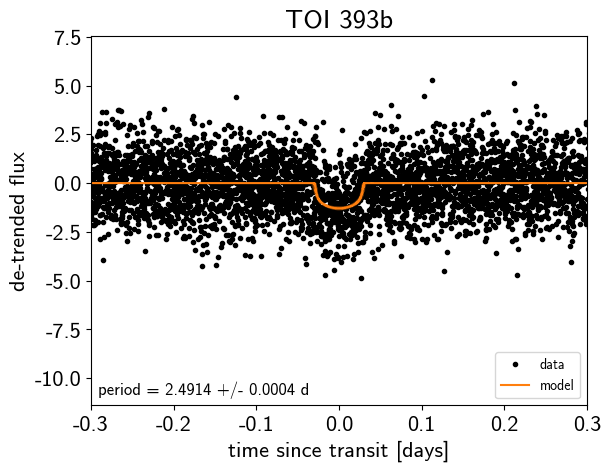

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

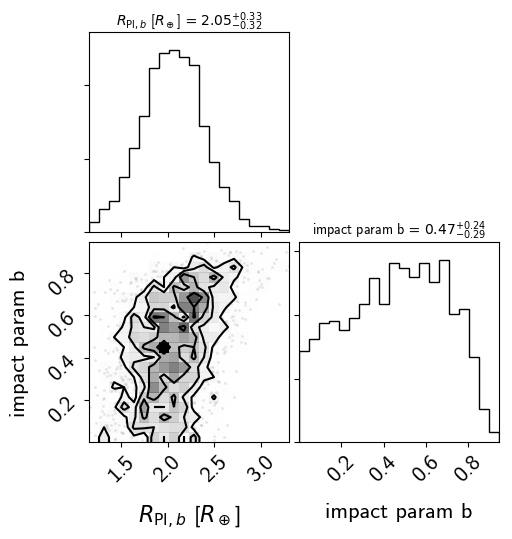

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

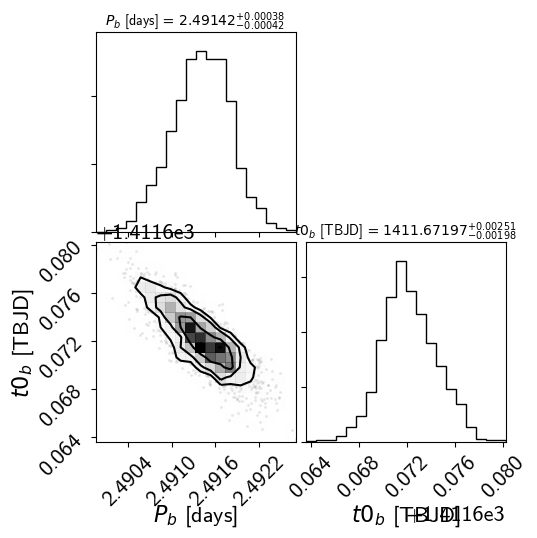

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

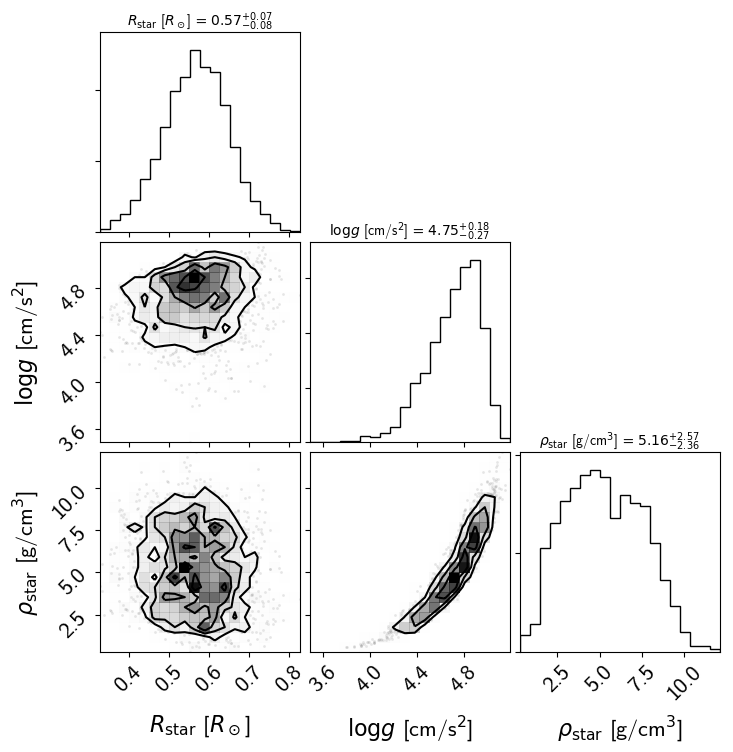

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3